## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'wavelet'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_wavelet_full_agriVision.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/agriVision/full/wavelet/gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 9000,
 3: 36000,
 4: 144000,
 5: 576000,
 6: 2304000,
 7: 9216000,
 8: 36864000,
 9: 147456000,
 10: 589824000}

Running 12760 CDFs


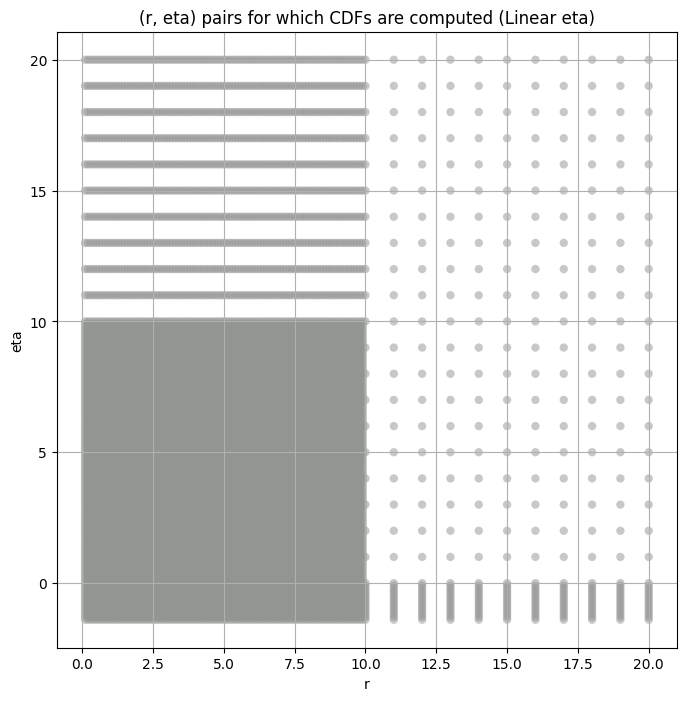

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [01:17<00:00, 1295.50it/s]


Layer 3


100%|██████████| 100000/100000 [01:20<00:00, 1241.41it/s]


Layer 4


100%|██████████| 100000/100000 [01:07<00:00, 1488.66it/s]


Layer 5


100%|██████████| 100000/100000 [01:07<00:00, 1491.20it/s]


Layer 6


100%|██████████| 100000/100000 [01:06<00:00, 1494.60it/s]


Layer 7


100%|██████████| 100000/100000 [01:10<00:00, 1421.32it/s]


Layer 8


100%|██████████| 100000/100000 [01:07<00:00, 1491.38it/s]


Layer 9


100%|██████████| 100000/100000 [01:08<00:00, 1455.65it/s]


Layer 10


100%|██████████| 100000/100000 [01:07<00:00, 1488.10it/s]


obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2      150199.610000  85008.820000  248364.750000   411.56780   85.166885   
3       33515.562000  19958.826000   52689.492000   366.28333  101.325680   
4        8690.716000   4650.655300   15441.943000   584.81120  124.448715   
5        1600.961900    772.053160    3722.834500  1309.72120   95.400870   
6         339.519200    152.123100    1059.839700  2687.21040   93.111470   
7          87.086320     35.836773     371.805480  4823.47600   72.400955   
8          29.883560     15.550574      79.512140  1685.91590   80.564125   
9           8.940126      4.773328      23.294840  1591.25370   83.608900   
10          1.353995      0.687269       4.314201  2561.70360   78.230440   

       kurt_upper  total_samples  
layer                             
2        581.2459         9000.0  
3        561.9847        36000.0  
4       1337.4540       144000.0  
5       3193.4438       576000.0  
6       4763.5063      2304000.0  
7       6356.3230      9216000.0  
8       3720.9280     36864000.0  
9       3578.0354    147456000.0  
10      4657.2515    589824000.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                 
2      150199.610000  150199.609375    49061.066406    41599.718750   
3       33515.562000   33515.562500    15847.806641    13293.750000   
4        8690.716000    8690.715820     4907.681152     3975.847168   
5        1600.961900    1600.961914      811.841431      681.406860   
6         339.519200     339.519196      160.051163      134.268204   
7          87.086320      87.086319       37.291645       31.925646   
8          29.883560      29.883560       16.271616       13.733879   
9           8.940126       8.940126        4.999494        4.206563   
10          1.353995       1.353995        0.726007        0.616834   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        36892.738281     33270.292969     27887.832031     23950.009766   
3        11865.583008     10862.463867      9495.183594      8534.389648   
4         3506.442383      3187.657227      2776.332764      2505.125732   
5          606.318298       556.393005       488.218292       441.753448   
6          119.535164       109.897095        97.363503        89.021057   
7           28.962358        26.966175        24.342234        22.607412   
8           12.378371        11.527897        10.488269         9.835171   
9            3.788889         3.527214         3.196956         2.981408   
10           0.557254         0.518458         0.468063         0.434640   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2         20819.333984     18418.148438     16407.533203     12186.848633  
3          7792.391113      7185.210449      6685.344727      5581.000000  
4          2305.070312      2150.212646      2022.455566      1738.380005  
5           407.621704       380.677704       358.300659       309.209198  
6            82.758606        77.815407        73.771111        64.821739  
7            21.324076        20.311827        19.480629        17.636690  
8             9.357556         8.978262         8.661517         7.931287  
9             2.820497         2.691267         2.582854         2.332580  
10            0.409602         0.389516         0.372724         0.334114

####
Layer  2


100%|██████████| 12760/12760 [00:07<00:00, 1669.36it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.023569175105879192 150199.61


100%|██████████| 12760/12760 [00:07<00:00, 1771.20it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.012922811568866155 49061.066


100%|██████████| 12760/12760 [00:07<00:00, 1770.37it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.014262562175787363 41599.72


100%|██████████| 12760/12760 [00:06<00:00, 1858.46it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.01590579746480314 36892.74


100%|██████████| 12760/12760 [00:06<00:00, 1835.73it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.018071401865904946 33270.293


100%|██████████| 12760/12760 [00:07<00:00, 1805.14it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.023233461449231108 27887.832


100%|██████████| 12760/12760 [00:07<00:00, 1756.18it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.02739228995892351 23950.01


100%|██████████| 12760/12760 [00:06<00:00, 1856.94it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.032889655140019784 20819.334


100%|██████████| 12760/12760 [00:06<00:00, 1823.55it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.03811968557154316 18418.148


100%|██████████| 12760/12760 [00:07<00:00, 1783.90it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.04285036858627359 16407.533


100%|██████████| 12760/12760 [00:06<00:00, 1850.69it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.058808251094575215 12186.849
Number of samples: 9000, Without approximation : 9000.0


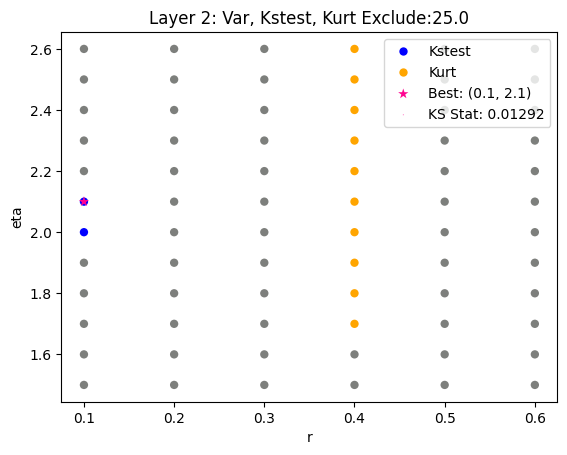

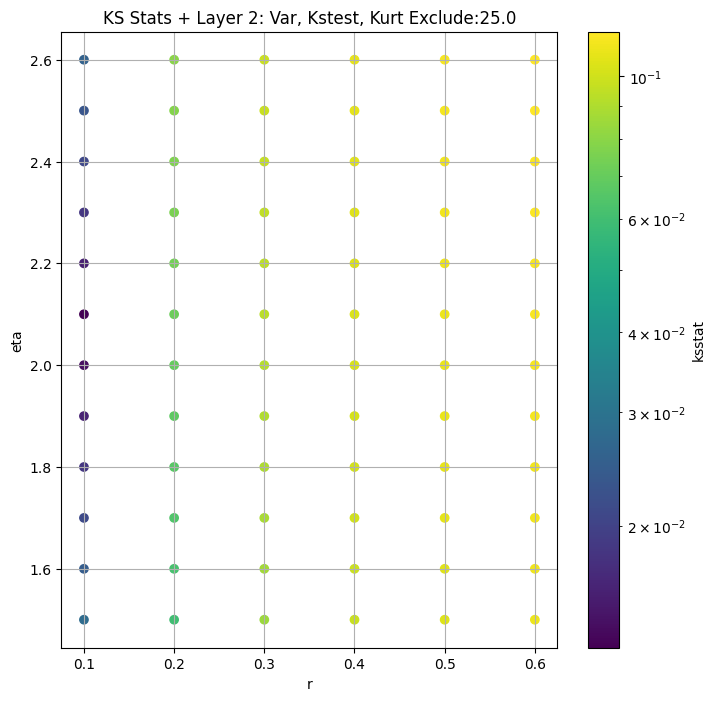

####
Layer  3


100%|██████████| 12760/12760 [00:25<00:00, 505.11it/s]


Finding Minimum after computing 12760 CDFs
3 0 0.028682580643103472 33515.562


100%|██████████| 12760/12760 [00:25<00:00, 504.94it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.01766833711609861 15847.807


100%|██████████| 12760/12760 [00:25<00:00, 502.27it/s]


Finding Minimum after computing 12760 CDFs
3 50 0.015472368920794427 13293.75


100%|██████████| 12760/12760 [00:25<00:00, 508.84it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.01427121521416963 11865.583


100%|██████████| 12760/12760 [00:25<00:00, 501.94it/s]


Finding Minimum after computing 12760 CDFs
3 100 0.013179288287096413 10862.464


100%|██████████| 12760/12760 [00:25<00:00, 508.13it/s]


Finding Minimum after computing 12760 CDFs
3 150 0.011751775009579024 9495.184


100%|██████████| 12760/12760 [00:25<00:00, 497.21it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.011263355961009247 8534.39


100%|██████████| 12760/12760 [00:25<00:00, 506.64it/s]


Finding Minimum after computing 12760 CDFs
3 250 0.011895107096348556 7792.391


100%|██████████| 12760/12760 [00:25<00:00, 505.97it/s]


Finding Minimum after computing 12760 CDFs
3 300 0.013077341772114504 7185.2104


100%|██████████| 12760/12760 [00:25<00:00, 508.50it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.014874007818294843 6685.3447


100%|██████████| 12760/12760 [00:25<00:00, 504.72it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.018486094714848522 5581.0
Number of samples: 36000, Without approximation : 36000.0


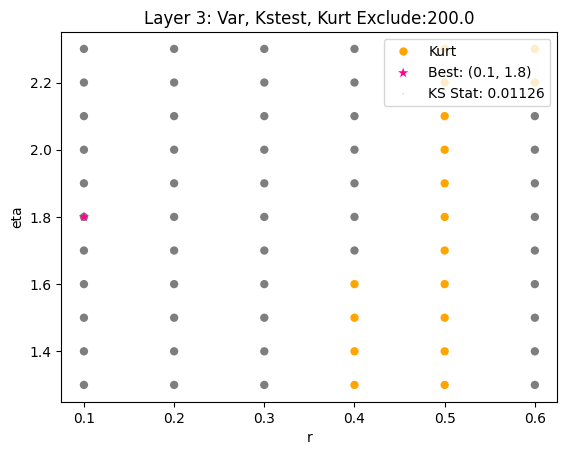

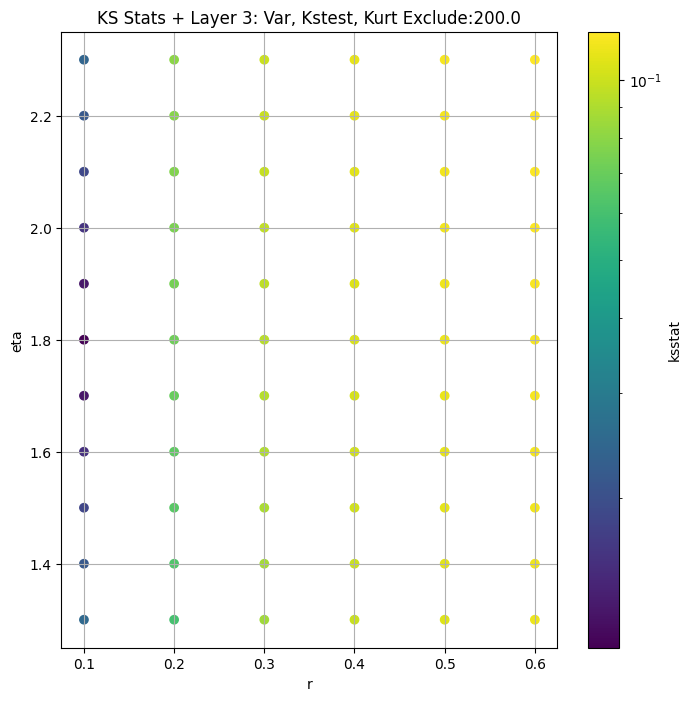

####
Layer  4


100%|██████████| 12760/12760 [01:08<00:00, 186.74it/s]


Finding Minimum after computing 12760 CDFs
4 0 0.03482731604979006 8690.716


100%|██████████| 12760/12760 [01:08<00:00, 185.07it/s]


Finding Minimum after computing 12760 CDFs
4 25 0.025472409961301068 4907.681


100%|██████████| 12760/12760 [01:08<00:00, 186.73it/s]


Finding Minimum after computing 12760 CDFs
4 50 0.020661192707253417 3975.8472


100%|██████████| 12760/12760 [01:12<00:00, 175.47it/s]


Finding Minimum after computing 12760 CDFs
4 75 0.019943777099456605 3506.4424


100%|██████████| 12760/12760 [01:08<00:00, 185.94it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.018454675663196474 3187.6572


100%|██████████| 12760/12760 [01:08<00:00, 186.51it/s]


Finding Minimum after computing 12760 CDFs
4 150 0.01452957283748424 2776.3328


100%|██████████| 12760/12760 [01:08<00:00, 186.04it/s]


Finding Minimum after computing 12760 CDFs
4 200 0.01406248100863261 2505.1257


100%|██████████| 12760/12760 [01:08<00:00, 187.57it/s]


Finding Minimum after computing 12760 CDFs
4 250 0.011728664986376813 2305.0703


100%|██████████| 12760/12760 [01:09<00:00, 184.69it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.010122784239287697 2150.2126


100%|██████████| 12760/12760 [01:08<00:00, 186.33it/s]


Finding Minimum after computing 12760 CDFs
4 350 0.008965811433313209 2022.4556


100%|██████████| 12760/12760 [01:09<00:00, 184.50it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.008795880176305185 1738.38
Number of samples: 100000, Without approximation : 144000.0


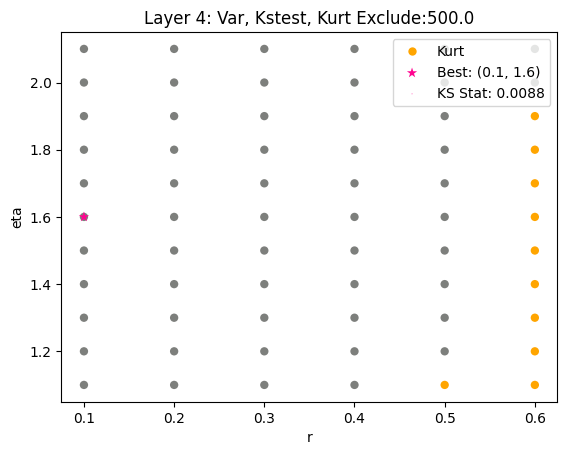

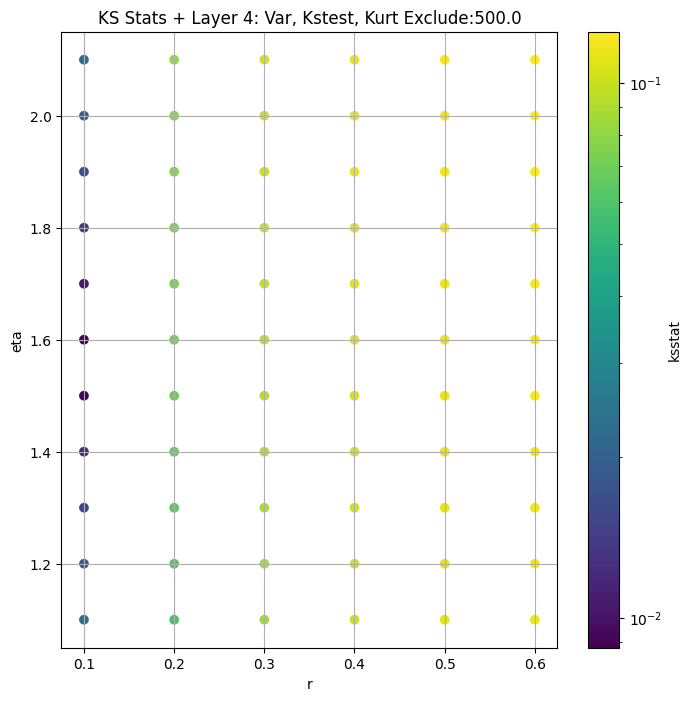

####
Layer  5


100%|██████████| 12760/12760 [01:09<00:00, 183.92it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.03604176589590474 1600.9619


100%|██████████| 12760/12760 [01:08<00:00, 187.18it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.02469516632641336 811.84143


100%|██████████| 12760/12760 [01:08<00:00, 186.21it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.02074235850239392 681.40686


100%|██████████| 12760/12760 [01:08<00:00, 186.32it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.01806882409061894 606.3183


100%|██████████| 12760/12760 [01:14<00:00, 171.84it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.015944043010524156 556.393


100%|██████████| 12760/12760 [01:08<00:00, 185.85it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.013489223880643095 488.2183


100%|██████████| 12760/12760 [01:08<00:00, 186.26it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.012335225599748867 441.75345


100%|██████████| 12760/12760 [01:13<00:00, 174.50it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.01035842516235147 407.6217


100%|██████████| 12760/12760 [01:08<00:00, 187.62it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.009783946492675999 380.6777


100%|██████████| 12760/12760 [01:08<00:00, 185.21it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.007817240006582127 358.30066


100%|██████████| 12760/12760 [01:10<00:00, 180.54it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.008051333552065665 309.2092
Number of samples: 100000, Without approximation : 576000.0


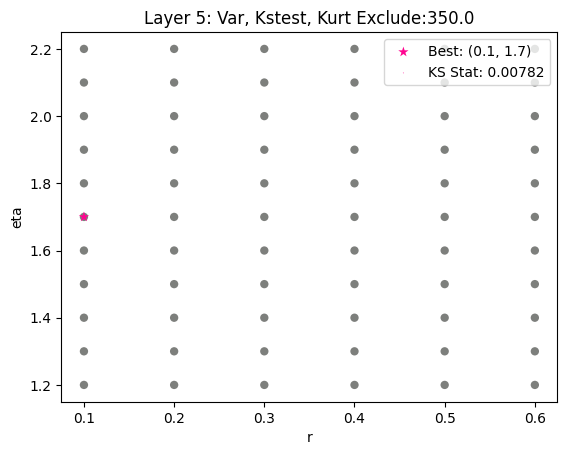

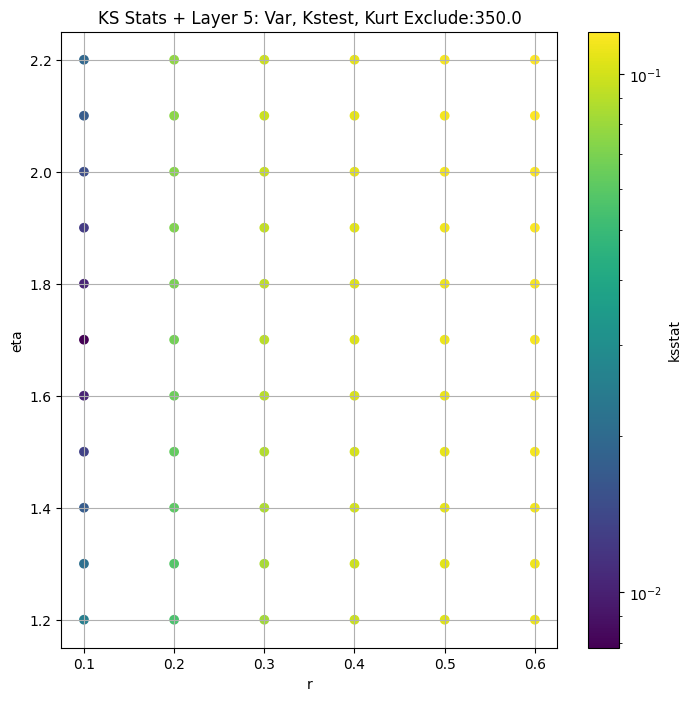

####
Layer  6


100%|██████████| 12760/12760 [01:08<00:00, 187.04it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.03487179820399637 339.5192


100%|██████████| 12760/12760 [01:08<00:00, 187.49it/s]


Finding Minimum after computing 12760 CDFs
6 25 0.021841530538673992 160.05116


100%|██████████| 12760/12760 [01:08<00:00, 186.01it/s]


Finding Minimum after computing 12760 CDFs
6 50 0.018471254814885762 134.2682


100%|██████████| 12760/12760 [01:08<00:00, 185.79it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.015454844808608592 119.535164


100%|██████████| 12760/12760 [01:08<00:00, 186.28it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.013880981216428667 109.897095


100%|██████████| 12760/12760 [01:08<00:00, 186.82it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.010993096736125585 97.3635


100%|██████████| 12760/12760 [01:08<00:00, 186.82it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.008710736175515932 89.02106


100%|██████████| 12760/12760 [01:09<00:00, 183.80it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.007140497381151967 82.758606


100%|██████████| 12760/12760 [01:08<00:00, 186.58it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.005388949907858542 77.81541


100%|██████████| 12760/12760 [01:08<00:00, 186.88it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.005423846973160229 73.77111


100%|██████████| 12760/12760 [01:08<00:00, 186.48it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.007098591605252946 64.82174
Number of samples: 100000, Without approximation : 2304000.0


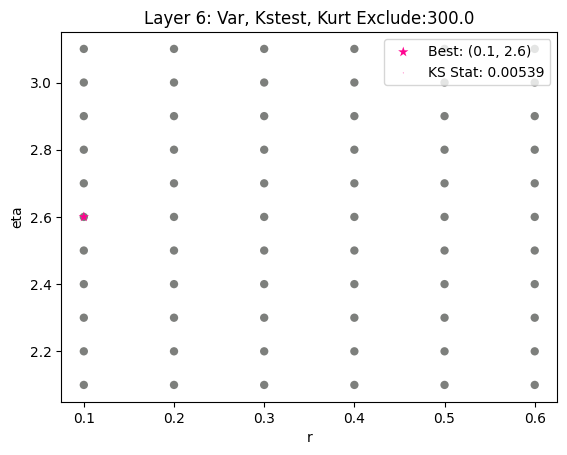

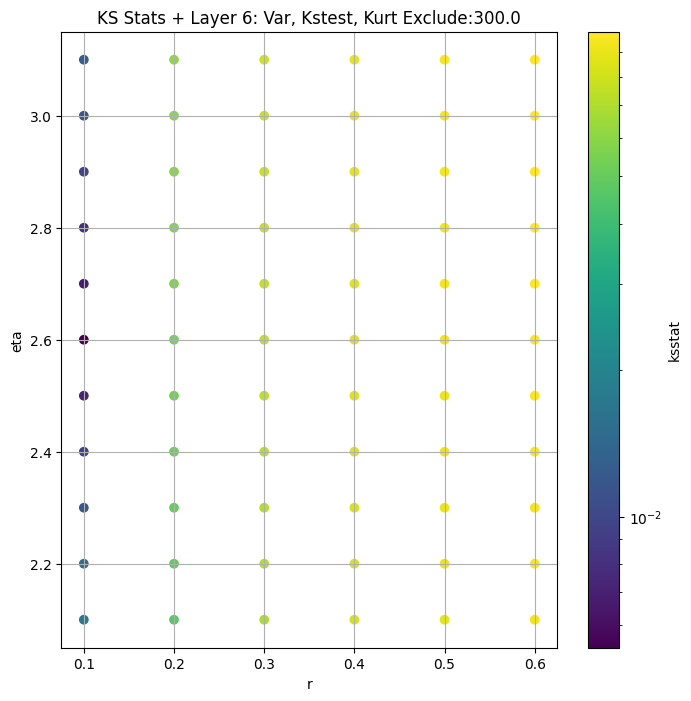

####
Layer  7


100%|██████████| 12760/12760 [01:08<00:00, 187.51it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.03323357018346184 87.08632


100%|██████████| 12760/12760 [01:08<00:00, 186.74it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.01584876953363512 37.291645


100%|██████████| 12760/12760 [01:08<00:00, 185.32it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.012214567263400977 31.925646


100%|██████████| 12760/12760 [01:08<00:00, 185.11it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.009814660647418205 28.962358


100%|██████████| 12760/12760 [01:08<00:00, 185.65it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.008415916995955675 26.966175


100%|██████████| 12760/12760 [01:08<00:00, 185.46it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.005475229718410635 24.342234


100%|██████████| 12760/12760 [01:08<00:00, 185.63it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.003893150369764009 22.607412


100%|██████████| 12760/12760 [01:08<00:00, 185.52it/s]


Finding Minimum after computing 12760 CDFs
7 250 0.0037421644349945327 21.324076


100%|██████████| 12760/12760 [01:08<00:00, 185.86it/s]


Finding Minimum after computing 12760 CDFs
7 300 0.004354904131757653 20.311827


100%|██████████| 12760/12760 [01:09<00:00, 184.23it/s]


Finding Minimum after computing 12760 CDFs
7 350 0.004936502614361404 19.480629


100%|██████████| 12760/12760 [01:11<00:00, 177.83it/s]


Finding Minimum after computing 12760 CDFs
7 500 0.0066274418759830755 17.63669
Number of samples: 100000, Without approximation : 9216000.0


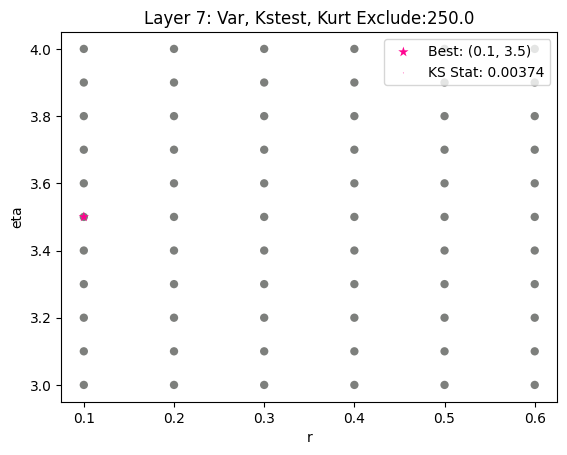

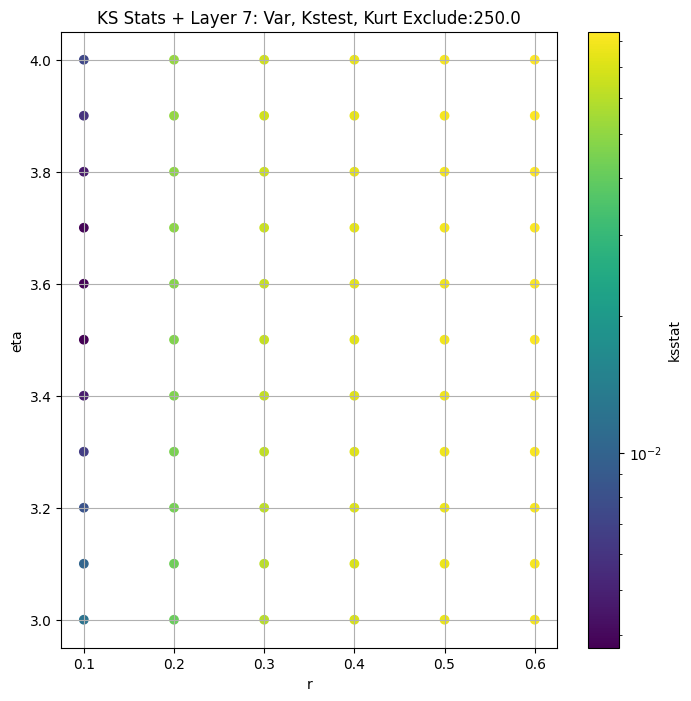

####
Layer  8


100%|██████████| 12760/12760 [01:08<00:00, 186.14it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.024633966203536327 29.88356


100%|██████████| 12760/12760 [01:11<00:00, 178.14it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.01147264995040409 16.271616


100%|██████████| 12760/12760 [01:08<00:00, 185.27it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.007678027473773663 13.733879


100%|██████████| 12760/12760 [01:09<00:00, 183.74it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.0053051688753057435 12.378371


100%|██████████| 12760/12760 [01:08<00:00, 186.07it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.003990217321181849 11.527897


100%|██████████| 12760/12760 [01:08<00:00, 186.26it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.0021906770088070404 10.488269


100%|██████████| 12760/12760 [01:08<00:00, 185.38it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.003191469839024408 9.835171


100%|██████████| 12760/12760 [01:12<00:00, 176.18it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.0038276832848487263 9.357556


100%|██████████| 12760/12760 [01:08<00:00, 185.64it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.004469163004905186 8.978262


100%|██████████| 12760/12760 [01:08<00:00, 186.85it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.005185692064962555 8.661517


100%|██████████| 12760/12760 [01:08<00:00, 186.75it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.00708794194282325 7.931287
Number of samples: 100000, Without approximation : 36864000.0


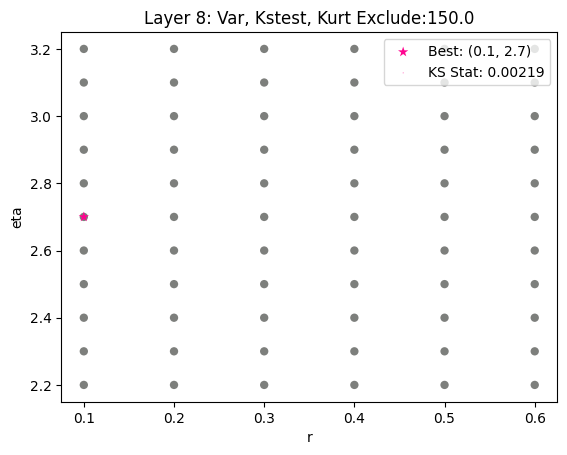

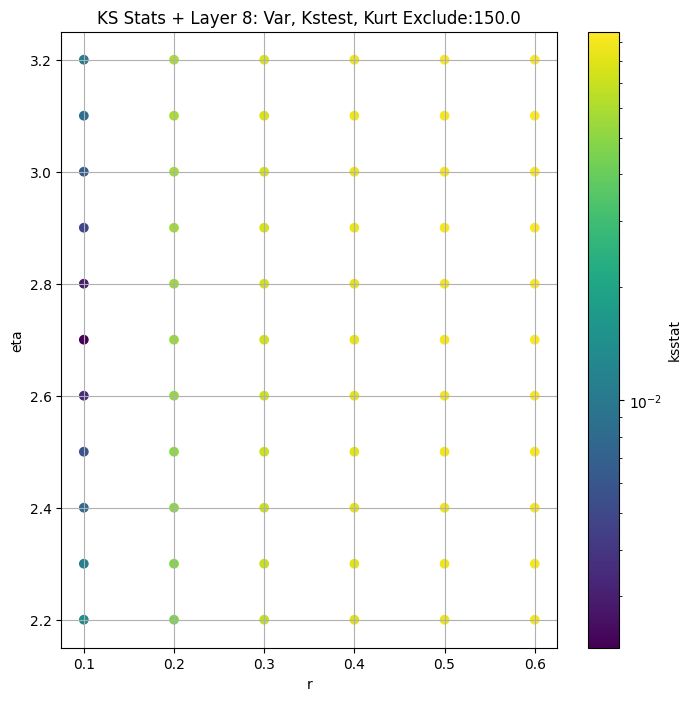

####
Layer  9


100%|██████████| 12760/12760 [01:08<00:00, 186.84it/s]


Finding Minimum after computing 12760 CDFs
9 0 0.026165067984434853 8.940126


100%|██████████| 12760/12760 [01:08<00:00, 186.67it/s]


Finding Minimum after computing 12760 CDFs
9 25 0.014617445107007354 4.9994936


100%|██████████| 12760/12760 [01:08<00:00, 185.37it/s]


Finding Minimum after computing 12760 CDFs
9 50 0.011258763786645976 4.206563


100%|██████████| 12760/12760 [01:08<00:00, 185.80it/s]


Finding Minimum after computing 12760 CDFs
9 75 0.009328091347316006 3.788889


100%|██████████| 12760/12760 [01:08<00:00, 185.51it/s]


Finding Minimum after computing 12760 CDFs
9 100 0.007118451575466089 3.527214


100%|██████████| 12760/12760 [01:08<00:00, 185.79it/s]


Finding Minimum after computing 12760 CDFs
9 150 0.005269058875417287 3.196956


100%|██████████| 12760/12760 [01:08<00:00, 185.62it/s]


Finding Minimum after computing 12760 CDFs
9 200 0.003818442581924958 2.9814084


100%|██████████| 12760/12760 [01:09<00:00, 183.52it/s]


Finding Minimum after computing 12760 CDFs
9 250 0.004755658790896417 2.8204966


100%|██████████| 12760/12760 [01:08<00:00, 186.28it/s]


Finding Minimum after computing 12760 CDFs
9 300 0.00518768970393794 2.6912675


100%|██████████| 12760/12760 [01:08<00:00, 185.55it/s]


Finding Minimum after computing 12760 CDFs
9 350 0.005734364407429306 2.582854


100%|██████████| 12760/12760 [01:08<00:00, 186.37it/s]


Finding Minimum after computing 12760 CDFs
9 500 0.007747038079266799 2.33258
Number of samples: 100000, Without approximation : 147456000.0


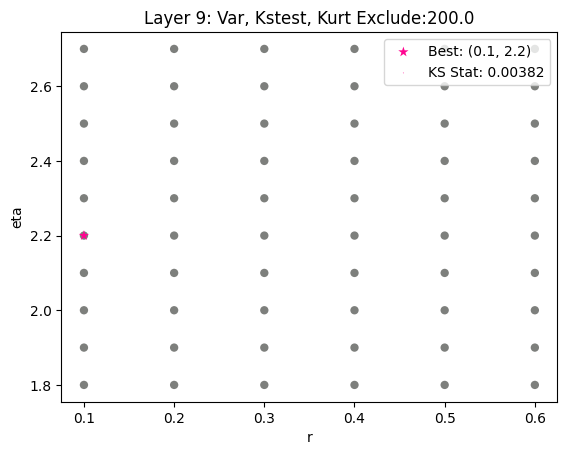

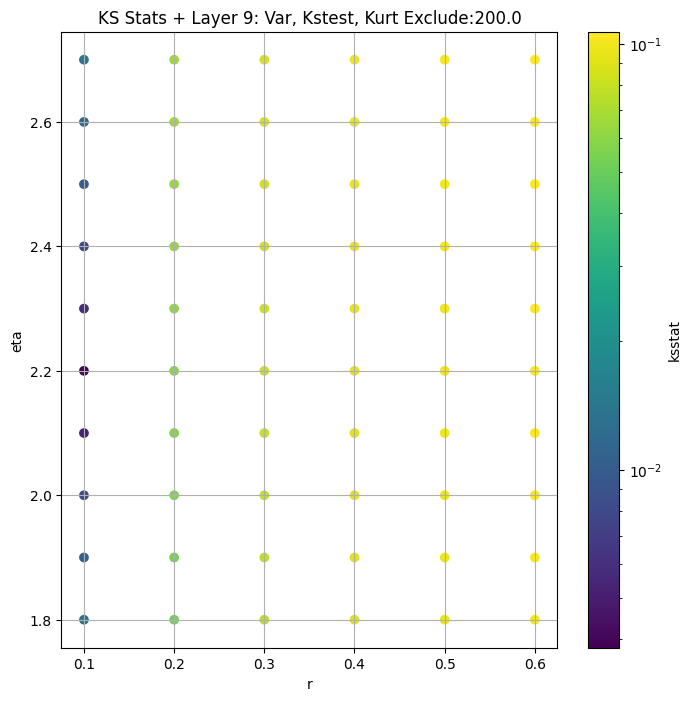

####
Layer  10


100%|██████████| 12760/12760 [01:08<00:00, 187.20it/s]


Finding Minimum after computing 12760 CDFs
10 0 0.027917803778487404 1.3539953


100%|██████████| 12760/12760 [01:08<00:00, 187.40it/s]


Finding Minimum after computing 12760 CDFs
10 25 0.016132059874527274 0.726007


100%|██████████| 12760/12760 [01:08<00:00, 187.07it/s]


Finding Minimum after computing 12760 CDFs
10 50 0.013999200432709163 0.6168341


100%|██████████| 12760/12760 [01:08<00:00, 186.91it/s]


Finding Minimum after computing 12760 CDFs
10 75 0.01148482643002191 0.5572545


100%|██████████| 12760/12760 [01:09<00:00, 183.95it/s]


Finding Minimum after computing 12760 CDFs
10 100 0.00963121605986289 0.5184585


100%|██████████| 12760/12760 [01:09<00:00, 184.23it/s]


Finding Minimum after computing 12760 CDFs
10 150 0.007264878232210559 0.46806347


100%|██████████| 12760/12760 [01:09<00:00, 183.99it/s]


Finding Minimum after computing 12760 CDFs
10 200 0.006840000000000013 0.4346397


100%|██████████| 12760/12760 [01:12<00:00, 176.41it/s]


Finding Minimum after computing 12760 CDFs
10 250 0.006839999999999902 0.40960217


100%|██████████| 12760/12760 [01:08<00:00, 185.79it/s]


Finding Minimum after computing 12760 CDFs
10 300 0.006839999999999791 0.38951564


100%|██████████| 12760/12760 [01:08<00:00, 185.13it/s]


Finding Minimum after computing 12760 CDFs
10 350 0.006839999999993407 0.3727239


100%|██████████| 12760/12760 [01:08<00:00, 186.02it/s]


Finding Minimum after computing 12760 CDFs
10 500 0.008082159020108781 0.3341141
Number of samples: 100000, Without approximation : 589824000.0


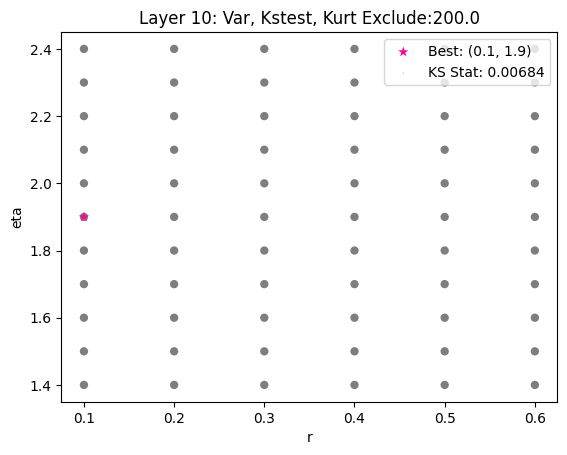

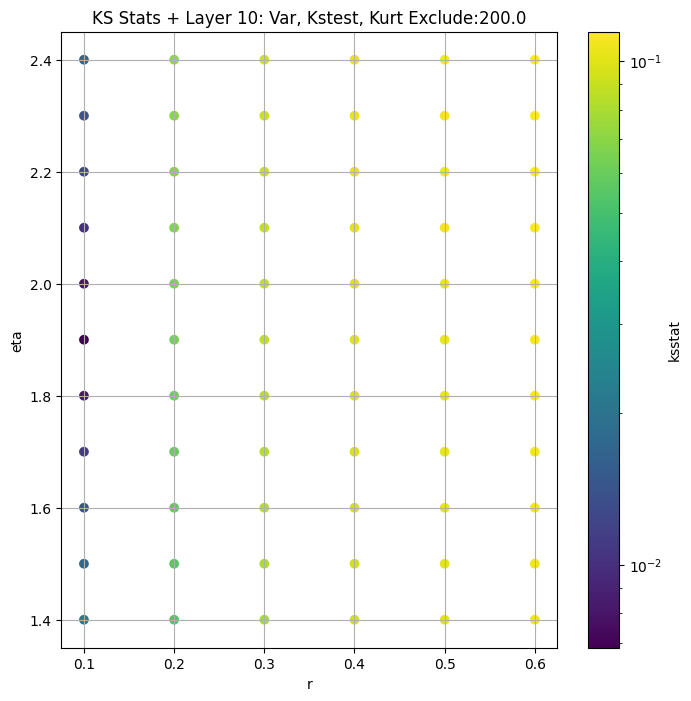

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2      150199.610000  85008.820000  248364.750000   411.56780   85.166885   
3       33515.562000  19958.826000   52689.492000   366.28333  101.325680   
4        8690.716000   4650.655300   15441.943000   584.81120  124.448715   
5        1600.961900    772.053160    3722.834500  1309.72120   95.400870   
6         339.519200    152.123100    1059.839700  2687.21040   93.111470   
7          87.086320     35.836773     371.805480  4823.47600   72.400955   
8          29.883560     15.550574      79.512140  1685.91590   80.564125   
9           8.940126      4.773328      23.294840  1591.25370   83.608900   
10          1.353995      0.687269       4.314201  2561.70360   78.230440   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        581.2459         9000.0             0.012923        0.1          2.1   
3        561.9847        36000.0             0.011263        0.1          1.8   
4       1337.4540       144000.0             0.008796        0.1          1.6   
5       3193.4438       576000.0             0.007817        0.1          1.7   
6       4763.5063      2304000.0             0.005389        0.1          2.6   
7       6356.3230      9216000.0             0.003742        0.1          3.5   
8       3720.9280     36864000.0             0.002191        0.1          2.7   
9       3578.0354    147456000.0             0.003818        0.1          2.2   
10      4657.2515    589824000.0             0.006840        0.1          1.9   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       4.237969e-12                    25.0        49061.066000   
3       1.598328e-12                   200.0         8534.390000   
4       5.651448e-13                   500.0         1738.380000   
5       8.807253e-14                   350.0          358.300660   
6       2.087545e-15                   300.0           77.815410   
7       9.353012e-17                   250.0           21.324076   
8       2.261974e-16                   150.0           10.488269   
9       2.015519e-16                   200.0            2.981408   
10      6.246955e-17                   200.0            0.434640   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.014297  
3                     0.007153  
4                     0.003578  
5                     0.001789  
6                     0.000895  
7                     0.000447  
8                     0.000224  
9                     0.000112  
10                    0.000056

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


100%|██████████| 522/522 [00:00<00:00, 1139.91it/s]


Finding Minimum after computing 522 CDFs
layer 2, 25.0 + 100 = 125, ksstat: 0.022283453817008136, var: 30326.560546875


100%|██████████| 522/522 [00:00<00:00, 1851.17it/s]


Finding Minimum after computing 522 CDFs
layer 2, 25.0 + 75 = 100, ksstat: 0.019888567454627748, var: 33270.29296875


100%|██████████| 522/522 [00:00<00:00, 1866.40it/s]


Finding Minimum after computing 522 CDFs
layer 2, 25.0 + 50 = 75, ksstat: 0.017345493411091262, var: 36892.73828125


100%|██████████| 522/522 [00:00<00:00, 1840.43it/s]


Finding Minimum after computing 522 CDFs
layer 2, 25.0 + 25 = 50, ksstat: 0.014548176630388321, var: 41599.71875


100%|██████████| 522/522 [00:00<00:00, 1859.09it/s]


Finding Minimum after computing 522 CDFs
layer 2, 25.0 + 0 = 25, ksstat: 0.0123415332985094, var: 49061.06640625


100%|██████████| 522/522 [00:00<00:00, 1855.38it/s]


Finding Minimum after computing 522 CDFs
layer 2, 25.0 + -25 = 0, ksstat: 0.023955265607137455, var: 150199.609375
Number of samples: 9000, Without approximation : 9000.0


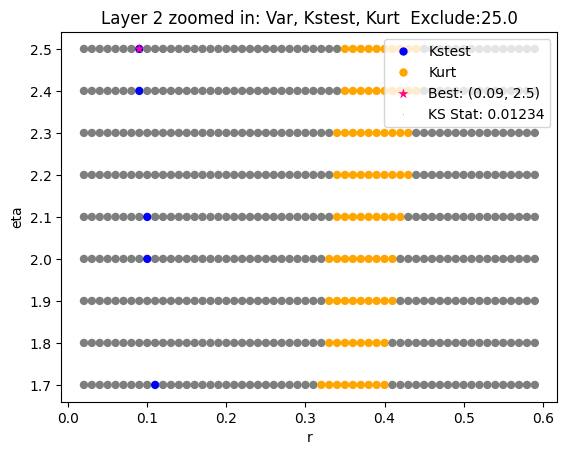

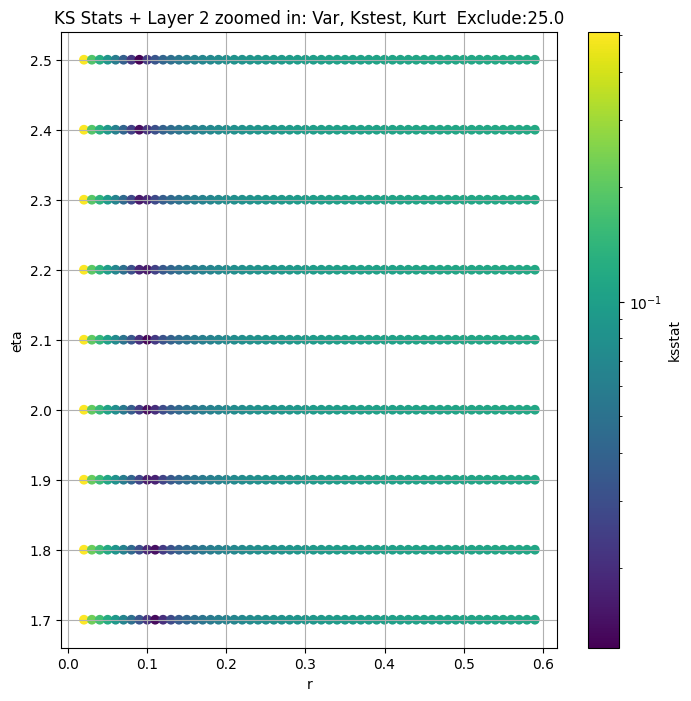

Layer 3


100%|██████████| 580/580 [00:01<00:00, 483.94it/s]


Finding Minimum after computing 580 CDFs
layer 3, 200.0 + 100 = 300, ksstat: 0.015128194371488046, var: 7185.21044921875


100%|██████████| 580/580 [00:01<00:00, 497.10it/s]


Finding Minimum after computing 580 CDFs
layer 3, 200.0 + 75 = 275, ksstat: 0.01429765602241595, var: 7472.97900390625


100%|██████████| 580/580 [00:01<00:00, 510.18it/s]


Finding Minimum after computing 580 CDFs
layer 3, 200.0 + 50 = 250, ksstat: 0.013306103072710296, var: 7792.39111328125


100%|██████████| 580/580 [00:01<00:00, 508.93it/s]


Finding Minimum after computing 580 CDFs
layer 3, 200.0 + 25 = 225, ksstat: 0.012189726259422162, var: 8143.23779296875


100%|██████████| 580/580 [00:01<00:00, 496.22it/s]


Finding Minimum after computing 580 CDFs
layer 3, 200.0 + 0 = 200, ksstat: 0.011250391699728302, var: 8534.3896484375


100%|██████████| 580/580 [00:01<00:00, 508.83it/s]


Finding Minimum after computing 580 CDFs
layer 3, 200.0 + -25 = 175, ksstat: 0.011167624228471063, var: 8979.4267578125


100%|██████████| 580/580 [00:01<00:00, 509.01it/s]


Finding Minimum after computing 580 CDFs
layer 3, 200.0 + -50 = 150, ksstat: 0.011442026276193451, var: 9495.18359375


100%|██████████| 580/580 [00:01<00:00, 509.27it/s]


Finding Minimum after computing 580 CDFs
layer 3, 200.0 + -75 = 125, ksstat: 0.011449184551047709, var: 10115.6455078125


100%|██████████| 580/580 [00:01<00:00, 499.40it/s]


Finding Minimum after computing 580 CDFs
layer 3, 200.0 + -100 = 100, ksstat: 0.012670199973784935, var: 10862.4638671875
Number of samples: 36000, Without approximation : 36000.0


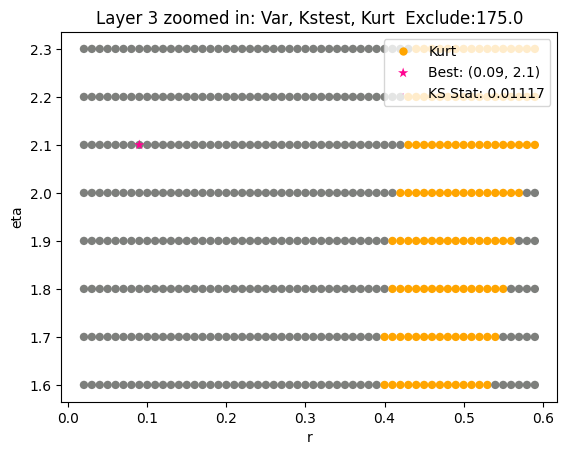

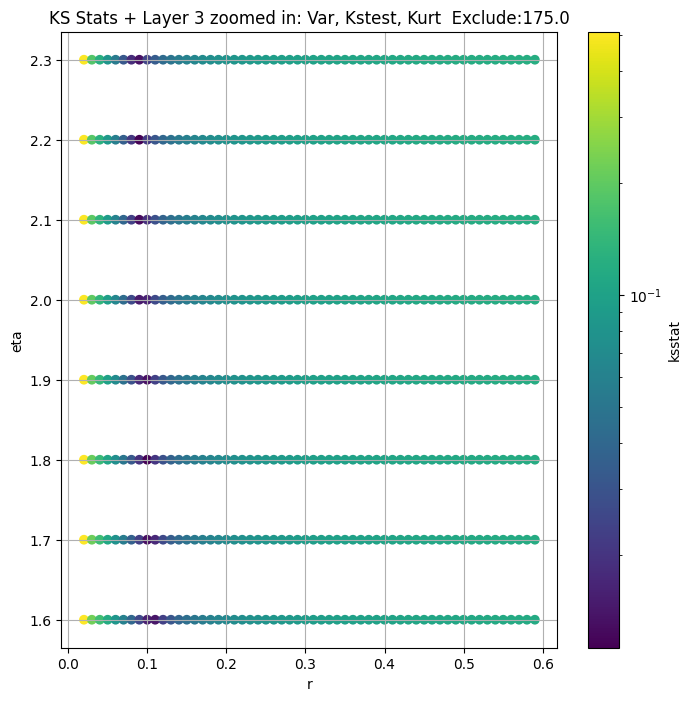

Layer 4


100%|██████████| 522/522 [00:02<00:00, 183.81it/s]


Finding Minimum after computing 522 CDFs
layer 4, 500.0 + 100 = 600, ksstat: 0.010085809730361089, var: 1598.7733154296875


100%|██████████| 522/522 [00:02<00:00, 186.54it/s]


Finding Minimum after computing 522 CDFs
layer 4, 500.0 + 75 = 575, ksstat: 0.009711815324680802, var: 1631.0174560546875


100%|██████████| 522/522 [00:02<00:00, 185.53it/s]


Finding Minimum after computing 522 CDFs
layer 4, 500.0 + 50 = 550, ksstat: 0.009440657584660592, var: 1664.9808349609375


100%|██████████| 522/522 [00:02<00:00, 188.01it/s]


Finding Minimum after computing 522 CDFs
layer 4, 500.0 + 25 = 525, ksstat: 0.009118367745440285, var: 1700.7435302734375


100%|██████████| 522/522 [00:02<00:00, 187.65it/s]


Finding Minimum after computing 522 CDFs
layer 4, 500.0 + 0 = 500, ksstat: 0.008717105916206135, var: 1738.3800048828125


100%|██████████| 522/522 [00:02<00:00, 184.64it/s]


Finding Minimum after computing 522 CDFs
layer 4, 500.0 + -25 = 475, ksstat: 0.008463121512926136, var: 1778.067626953125


100%|██████████| 522/522 [00:02<00:00, 187.87it/s]


Finding Minimum after computing 522 CDFs
layer 4, 500.0 + -50 = 450, ksstat: 0.007986955809325458, var: 1820.04296875


100%|██████████| 522/522 [00:02<00:00, 188.10it/s]


Finding Minimum after computing 522 CDFs
layer 4, 500.0 + -75 = 425, ksstat: 0.007760880117917021, var: 1864.94873046875


100%|██████████| 522/522 [00:02<00:00, 188.03it/s]


Finding Minimum after computing 522 CDFs
layer 4, 500.0 + -100 = 400, ksstat: 0.00806300568226781, var: 1913.5447998046875
Number of samples: 100000, Without approximation : 144000.0


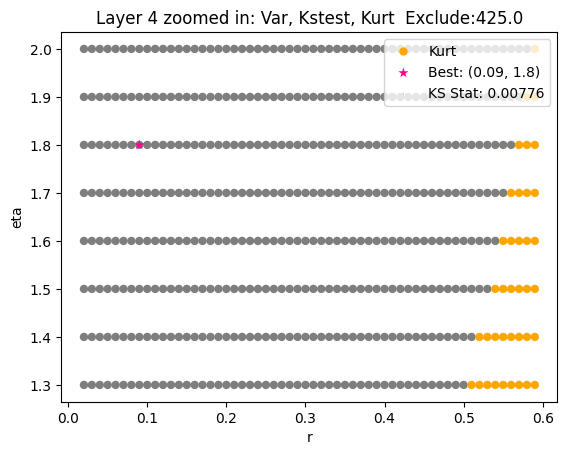

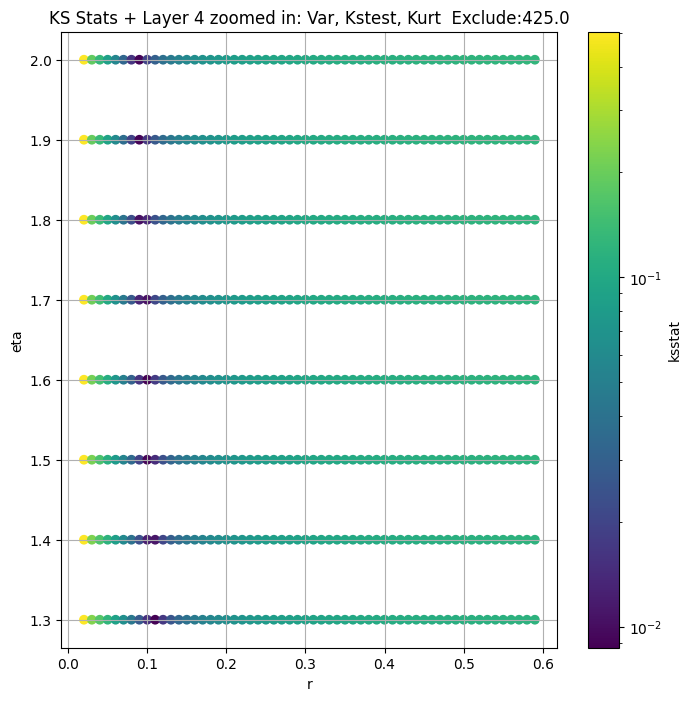

Layer 5


100%|██████████| 522/522 [00:02<00:00, 187.40it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 100 = 450, ksstat: 0.007528984414732709, var: 323.35931396484375


100%|██████████| 522/522 [00:02<00:00, 188.20it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 75 = 425, ksstat: 0.007262728805919272, var: 331.1462707519531


100%|██████████| 522/522 [00:02<00:00, 186.00it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 50 = 400, ksstat: 0.007036598676742445, var: 339.4757385253906


100%|██████████| 522/522 [00:02<00:00, 186.20it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 25 = 375, ksstat: 0.00792998741395795, var: 348.4898376464844


100%|██████████| 522/522 [00:02<00:00, 188.12it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 0 = 350, ksstat: 0.007817240006582127, var: 358.3006591796875


100%|██████████| 522/522 [00:02<00:00, 188.24it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + -25 = 325, ksstat: 0.007850907284205344, var: 368.9902038574219


100%|██████████| 522/522 [00:02<00:00, 186.38it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + -50 = 300, ksstat: 0.008934109922534461, var: 380.6777038574219


100%|██████████| 522/522 [00:02<00:00, 188.61it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + -75 = 275, ksstat: 0.009604138213700097, var: 393.47265625


100%|██████████| 522/522 [00:02<00:00, 188.32it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + -100 = 250, ksstat: 0.010352316540332307, var: 407.6217041015625
Number of samples: 100000, Without approximation : 576000.0


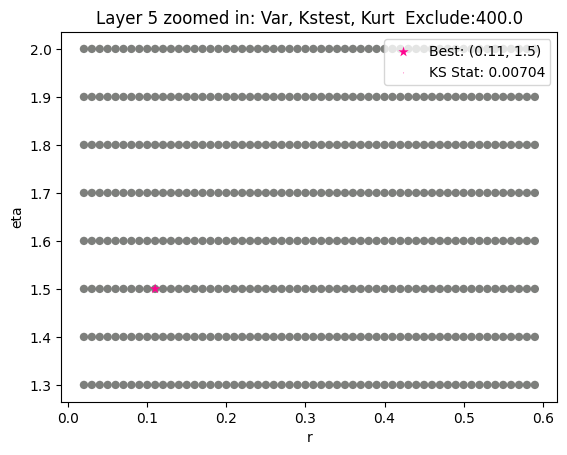

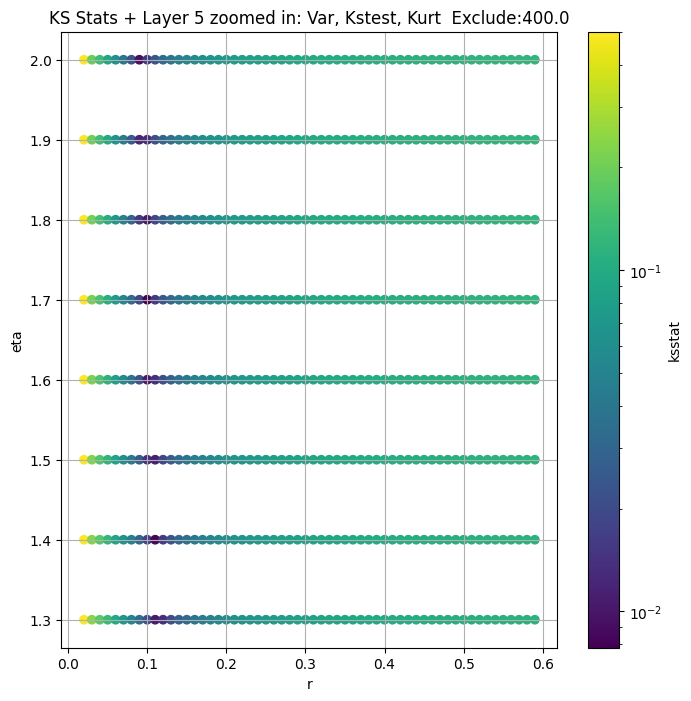

Layer 6


100%|██████████| 522/522 [00:02<00:00, 178.22it/s]


Finding Minimum after computing 522 CDFs
layer 6, 300.0 + 100 = 400, ksstat: 0.0059809159531230005, var: 70.3510971069336


100%|██████████| 522/522 [00:02<00:00, 188.41it/s]


Finding Minimum after computing 522 CDFs
layer 6, 300.0 + 75 = 375, ksstat: 0.00567714402366537, var: 71.99275207519531


100%|██████████| 522/522 [00:02<00:00, 187.42it/s]


Finding Minimum after computing 522 CDFs
layer 6, 300.0 + 50 = 350, ksstat: 0.005423846973160229, var: 73.77111053466797


100%|██████████| 522/522 [00:02<00:00, 185.96it/s]


Finding Minimum after computing 522 CDFs
layer 6, 300.0 + 25 = 325, ksstat: 0.005112910862585696, var: 75.70270538330078


100%|██████████| 522/522 [00:02<00:00, 187.20it/s]


Finding Minimum after computing 522 CDFs
layer 6, 300.0 + 0 = 300, ksstat: 0.005388949907858542, var: 77.8154067993164


100%|██████████| 522/522 [00:02<00:00, 188.43it/s]


Finding Minimum after computing 522 CDFs
layer 6, 300.0 + -25 = 275, ksstat: 0.0062022821391388705, var: 80.1509780883789


100%|██████████| 522/522 [00:02<00:00, 186.14it/s]


Finding Minimum after computing 522 CDFs
layer 6, 300.0 + -50 = 250, ksstat: 0.006742924063681988, var: 82.75860595703125


100%|██████████| 522/522 [00:02<00:00, 188.45it/s]


Finding Minimum after computing 522 CDFs
layer 6, 300.0 + -75 = 225, ksstat: 0.0073134866312730695, var: 85.6884994506836


100%|██████████| 522/522 [00:02<00:00, 188.45it/s]


Finding Minimum after computing 522 CDFs
layer 6, 300.0 + -100 = 200, ksstat: 0.008642563507108458, var: 89.02105712890625
Number of samples: 100000, Without approximation : 2304000.0


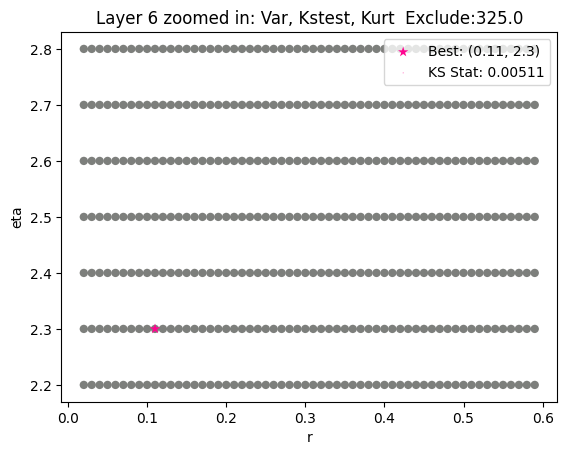

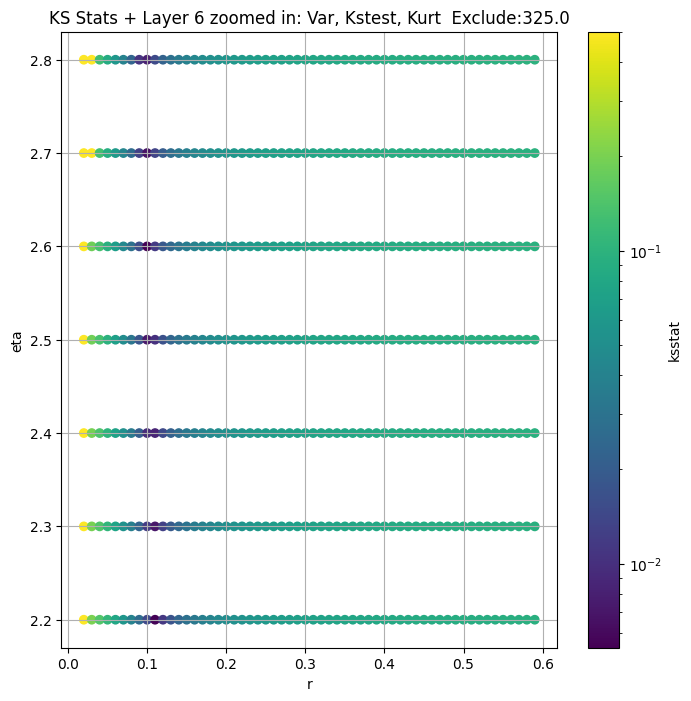

Layer 7


100%|██████████| 522/522 [00:02<00:00, 175.35it/s]


Finding Minimum after computing 522 CDFs
layer 7, 250.0 + 100 = 350, ksstat: 0.004974782361931052, var: 19.480628967285156


100%|██████████| 522/522 [00:02<00:00, 187.32it/s]


Finding Minimum after computing 522 CDFs
layer 7, 250.0 + 75 = 325, ksstat: 0.004665707508412886, var: 19.877294540405273


100%|██████████| 522/522 [00:02<00:00, 188.05it/s]


Finding Minimum after computing 522 CDFs
layer 7, 250.0 + 50 = 300, ksstat: 0.004347987301284606, var: 20.311826705932617


100%|██████████| 522/522 [00:02<00:00, 186.32it/s]


Finding Minimum after computing 522 CDFs
layer 7, 250.0 + 25 = 275, ksstat: 0.004038863275958482, var: 20.79116439819336


100%|██████████| 522/522 [00:02<00:00, 187.64it/s]


Finding Minimum after computing 522 CDFs
layer 7, 250.0 + 0 = 250, ksstat: 0.0037421644349945327, var: 21.32407569885254


100%|██████████| 522/522 [00:02<00:00, 183.39it/s]


Finding Minimum after computing 522 CDFs
layer 7, 250.0 + -25 = 225, ksstat: 0.0034549201410801755, var: 21.92387580871582


100%|██████████| 522/522 [00:02<00:00, 182.59it/s]


Finding Minimum after computing 522 CDFs
layer 7, 250.0 + -50 = 200, ksstat: 0.0032084741395540517, var: 22.607412338256836


100%|██████████| 522/522 [00:02<00:00, 188.29it/s]


Finding Minimum after computing 522 CDFs
layer 7, 250.0 + -75 = 175, ksstat: 0.004036429967051336, var: 23.4002742767334


100%|██████████| 522/522 [00:02<00:00, 188.42it/s]


Finding Minimum after computing 522 CDFs
layer 7, 250.0 + -100 = 150, ksstat: 0.005119849298308998, var: 24.342233657836914
Number of samples: 100000, Without approximation : 9216000.0


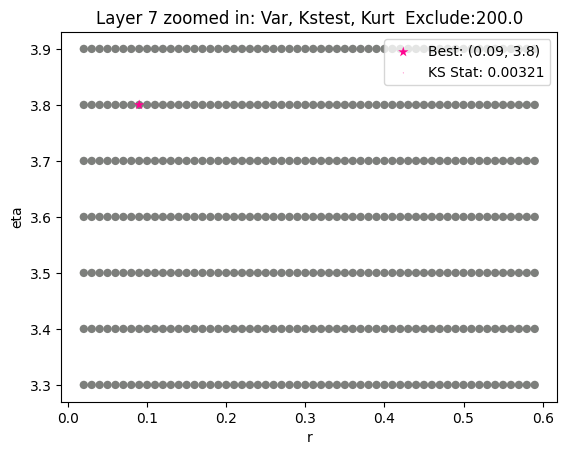

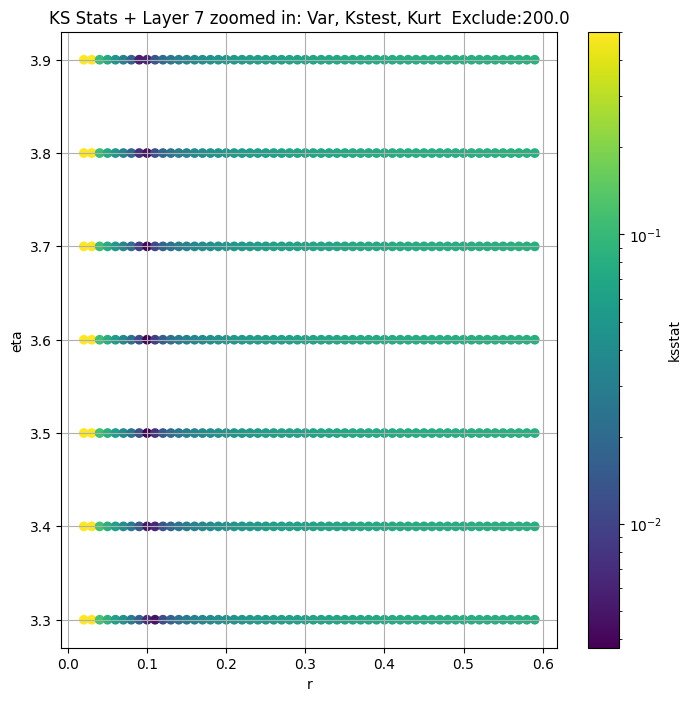

Layer 8


100%|██████████| 522/522 [00:02<00:00, 183.08it/s]


Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 100 = 250, ksstat: 0.004175096615997798, var: 9.357556343078613


100%|██████████| 522/522 [00:02<00:00, 188.22it/s]


Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 75 = 225, ksstat: 0.003646248737437241, var: 9.580748558044434


100%|██████████| 522/522 [00:02<00:00, 188.21it/s]


Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 50 = 200, ksstat: 0.0031452975132467698, var: 9.83517074584961


100%|██████████| 522/522 [00:02<00:00, 184.98it/s]


Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 25 = 175, ksstat: 0.002624549577725399, var: 10.13187313079834


100%|██████████| 522/522 [00:02<00:00, 187.06it/s]


Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 0 = 150, ksstat: 0.0021905876168901717, var: 10.488268852233887


100%|██████████| 522/522 [00:02<00:00, 188.40it/s]


Finding Minimum after computing 522 CDFs
layer 8, 150.0 + -25 = 125, ksstat: 0.002282516239956345, var: 10.935249328613281


100%|██████████| 522/522 [00:02<00:00, 186.29it/s]


Finding Minimum after computing 522 CDFs
layer 8, 150.0 + -50 = 100, ksstat: 0.003196516685566808, var: 11.527896881103516


100%|██████████| 522/522 [00:02<00:00, 186.07it/s]


Finding Minimum after computing 522 CDFs
layer 8, 150.0 + -75 = 75, ksstat: 0.004647415636535632, var: 12.378371238708496


100%|██████████| 522/522 [00:02<00:00, 188.38it/s]


Finding Minimum after computing 522 CDFs
layer 8, 150.0 + -100 = 50, ksstat: 0.006915676101010515, var: 13.733879089355469
Number of samples: 100000, Without approximation : 36864000.0


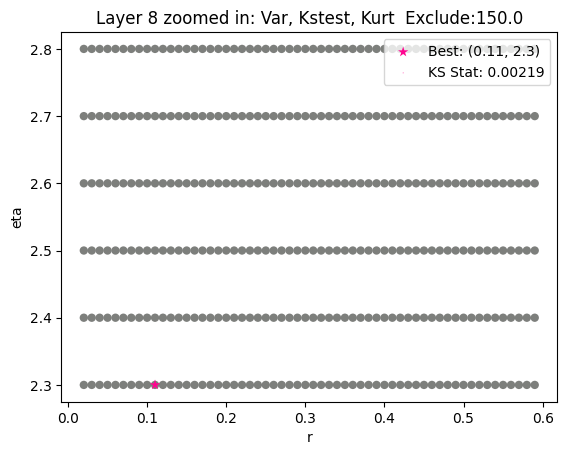

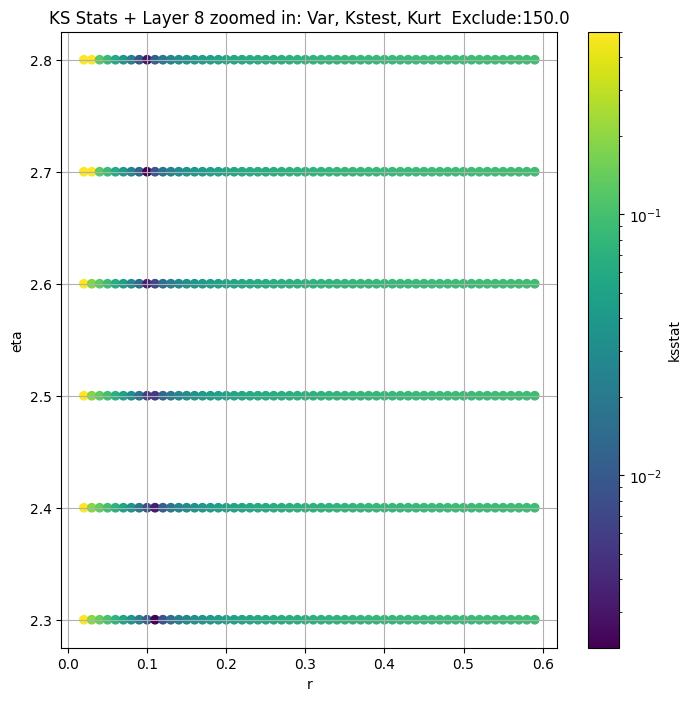

Layer 9


100%|██████████| 522/522 [00:02<00:00, 185.04it/s]


Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 100 = 300, ksstat: 0.005553019012394578, var: 2.691267490386963


100%|██████████| 522/522 [00:02<00:00, 187.81it/s]


Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 75 = 275, ksstat: 0.005107209630322414, var: 2.7527709007263184


100%|██████████| 522/522 [00:02<00:00, 186.08it/s]


Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 50 = 250, ksstat: 0.004704748093333079, var: 2.8204965591430664


100%|██████████| 522/522 [00:03<00:00, 170.58it/s]


Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 25 = 225, ksstat: 0.004232069676289961, var: 2.8959782123565674


100%|██████████| 522/522 [00:02<00:00, 187.74it/s]


Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 0 = 200, ksstat: 0.003818442581924958, var: 2.9814083576202393


100%|██████████| 522/522 [00:02<00:00, 187.66it/s]


Finding Minimum after computing 522 CDFs
layer 9, 200.0 + -25 = 175, ksstat: 0.003805200718831614, var: 3.0800540447235107


100%|██████████| 522/522 [00:02<00:00, 184.28it/s]


Finding Minimum after computing 522 CDFs
layer 9, 200.0 + -50 = 150, ksstat: 0.004702273288287873, var: 3.196955919265747


100%|██████████| 522/522 [00:02<00:00, 179.15it/s]


Finding Minimum after computing 522 CDFs
layer 9, 200.0 + -75 = 125, ksstat: 0.006134101195280767, var: 3.3408455848693848


100%|██████████| 522/522 [00:02<00:00, 186.71it/s]


Finding Minimum after computing 522 CDFs
layer 9, 200.0 + -100 = 100, ksstat: 0.0064039574981968606, var: 3.5272140502929688
Number of samples: 100000, Without approximation : 147456000.0


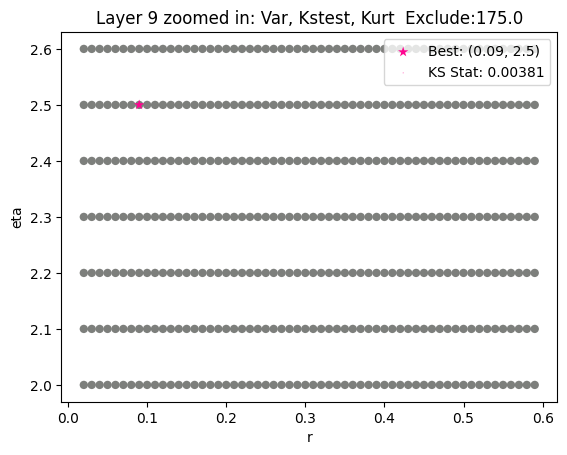

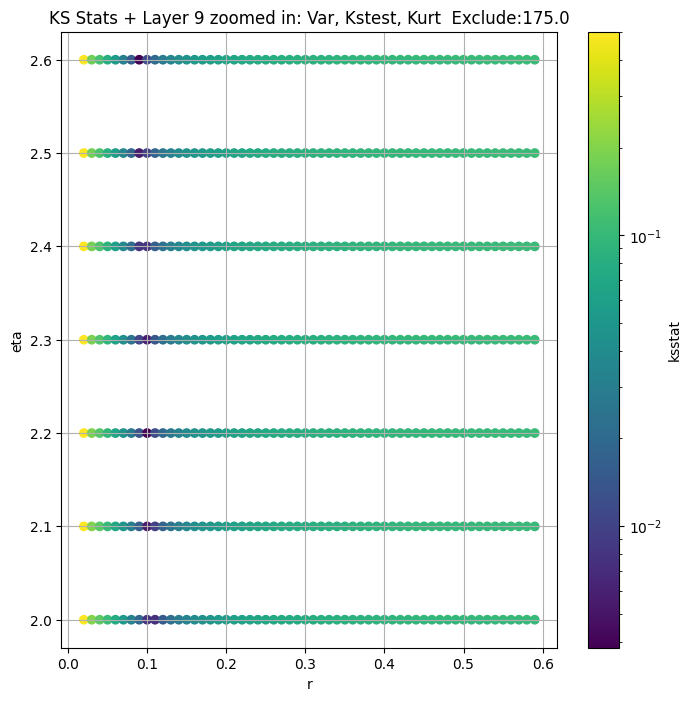

Layer 10


100%|██████████| 522/522 [00:02<00:00, 180.58it/s]


Finding Minimum after computing 522 CDFs
layer 10, 200.0 + 100 = 300, ksstat: 0.006839999999987689, var: 0.38951563835144043


100%|██████████| 522/522 [00:02<00:00, 188.14it/s]


Finding Minimum after computing 522 CDFs
layer 10, 200.0 + 75 = 275, ksstat: 0.006839999999987745, var: 0.3990877866744995


100%|██████████| 522/522 [00:02<00:00, 187.84it/s]


Finding Minimum after computing 522 CDFs
layer 10, 200.0 + 50 = 250, ksstat: 0.006839999999998958, var: 0.40960216522216797


100%|██████████| 522/522 [00:02<00:00, 183.59it/s]


Finding Minimum after computing 522 CDFs
layer 10, 200.0 + 25 = 225, ksstat: 0.00683999999999807, var: 0.42135870456695557


100%|██████████| 522/522 [00:02<00:00, 187.31it/s]


Finding Minimum after computing 522 CDFs
layer 10, 200.0 + 0 = 200, ksstat: 0.006839999999999902, var: 0.43463969230651855


100%|██████████| 522/522 [00:02<00:00, 186.95it/s]


Finding Minimum after computing 522 CDFs
layer 10, 200.0 + -25 = 175, ksstat: 0.006839999999999846, var: 0.4499532878398895


100%|██████████| 522/522 [00:02<00:00, 187.93it/s]


Finding Minimum after computing 522 CDFs
layer 10, 200.0 + -50 = 150, ksstat: 0.007008546271311783, var: 0.46806347370147705


100%|██████████| 522/522 [00:02<00:00, 188.05it/s]


Finding Minimum after computing 522 CDFs
layer 10, 200.0 + -75 = 125, ksstat: 0.008052914622220464, var: 0.4901871085166931


100%|██████████| 522/522 [00:02<00:00, 184.79it/s]


Finding Minimum after computing 522 CDFs
layer 10, 200.0 + -100 = 100, ksstat: 0.008704035392717496, var: 0.5184584856033325
Number of samples: 100000, Without approximation : 589824000.0


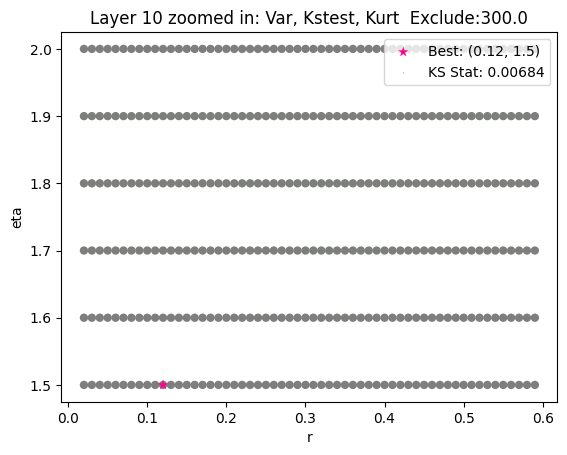

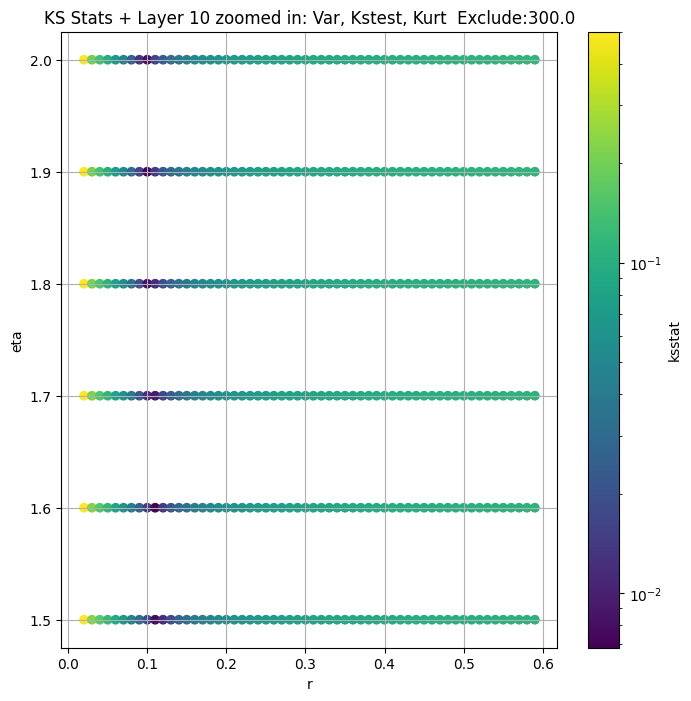

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2      150199.610000  85008.820000  248364.750000   411.56780   85.166885   
3       33515.562000  19958.826000   52689.492000   366.28333  101.325680   
4        8690.716000   4650.655300   15441.943000   584.81120  124.448715   
5        1600.961900    772.053160    3722.834500  1309.72120   95.400870   
6         339.519200    152.123100    1059.839700  2687.21040   93.111470   
7          87.086320     35.836773     371.805480  4823.47600   72.400955   
8          29.883560     15.550574      79.512140  1685.91590   80.564125   
9           8.940126      4.773328      23.294840  1591.25370   83.608900   
10          1.353995      0.687269       4.314201  2561.70360   78.230440   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        581.2459         9000.0             0.012923        0.1          2.1   
3        561.9847        36000.0             0.011263        0.1          1.8   
4       1337.4540       144000.0             0.008796        0.1          1.6   
5       3193.4438       576000.0             0.007817        0.1          1.7   
6       4763.5063      2304000.0             0.005389        0.1          2.6   
7       6356.3230      9216000.0             0.003742        0.1          3.5   
8       3720.9280     36864000.0             0.002191        0.1          2.7   
9       3578.0354    147456000.0             0.003818        0.1          2.2   
10      4657.2515    589824000.0             0.006840        0.1          1.9   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       4.237969e-12                    25.0        49061.066406   
3       1.598328e-12                   200.0         8979.426758   
4       5.651448e-13                   500.0         1864.948730   
5       8.807253e-14                   350.0          339.475739   
6       2.087545e-15                   300.0           75.702705   
7       9.353012e-17                   250.0           22.607412   
8       2.261974e-16                   150.0           10.488269   
9       2.015519e-16                   200.0            3.080054   
10      6.246955e-17                   200.0            0.389516   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.014297          0.012342    0.09       2.5   
3                     0.007153          0.011168    0.09       2.1   
4                     0.003578          0.007761    0.09       1.8   
5                     0.001789          0.007037    0.11       1.5   
6                     0.000895          0.005113    0.11       2.3   
7                     0.000447          0.003208    0.09       3.8   
8                     0.000224          0.002191    0.11       2.3   
9                     0.000112          0.003805    0.09       2.5   
10                    0.000056          0.006840    0.12       1.5   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      7.445200e-15                 25.0        12811  
3      3.894488e-15                175.0        15187  
4      1.908987e-15                425.0        30375  
5      8.839685e-12                400.0        36000  
6      2.921297e-13                325.0        72000  
7      1.976105e-19                200.0       182250  
8      4.047325e-14                150.0       389236  
9      4.674097e-19                175.0       121500  
10     2.873110e-13                300.0        40500

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

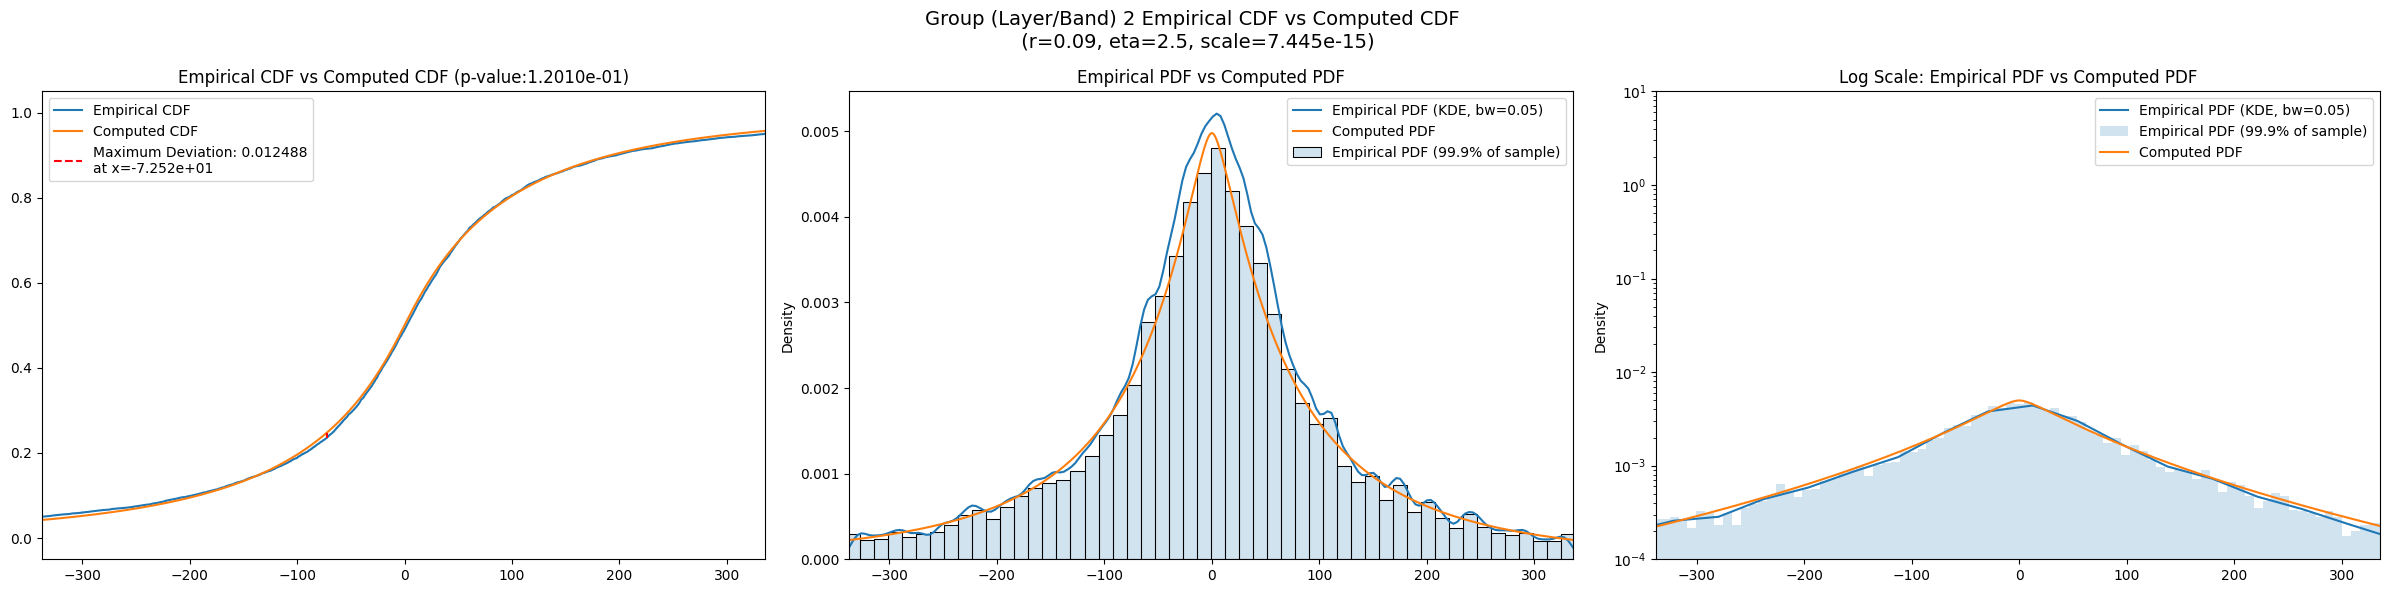

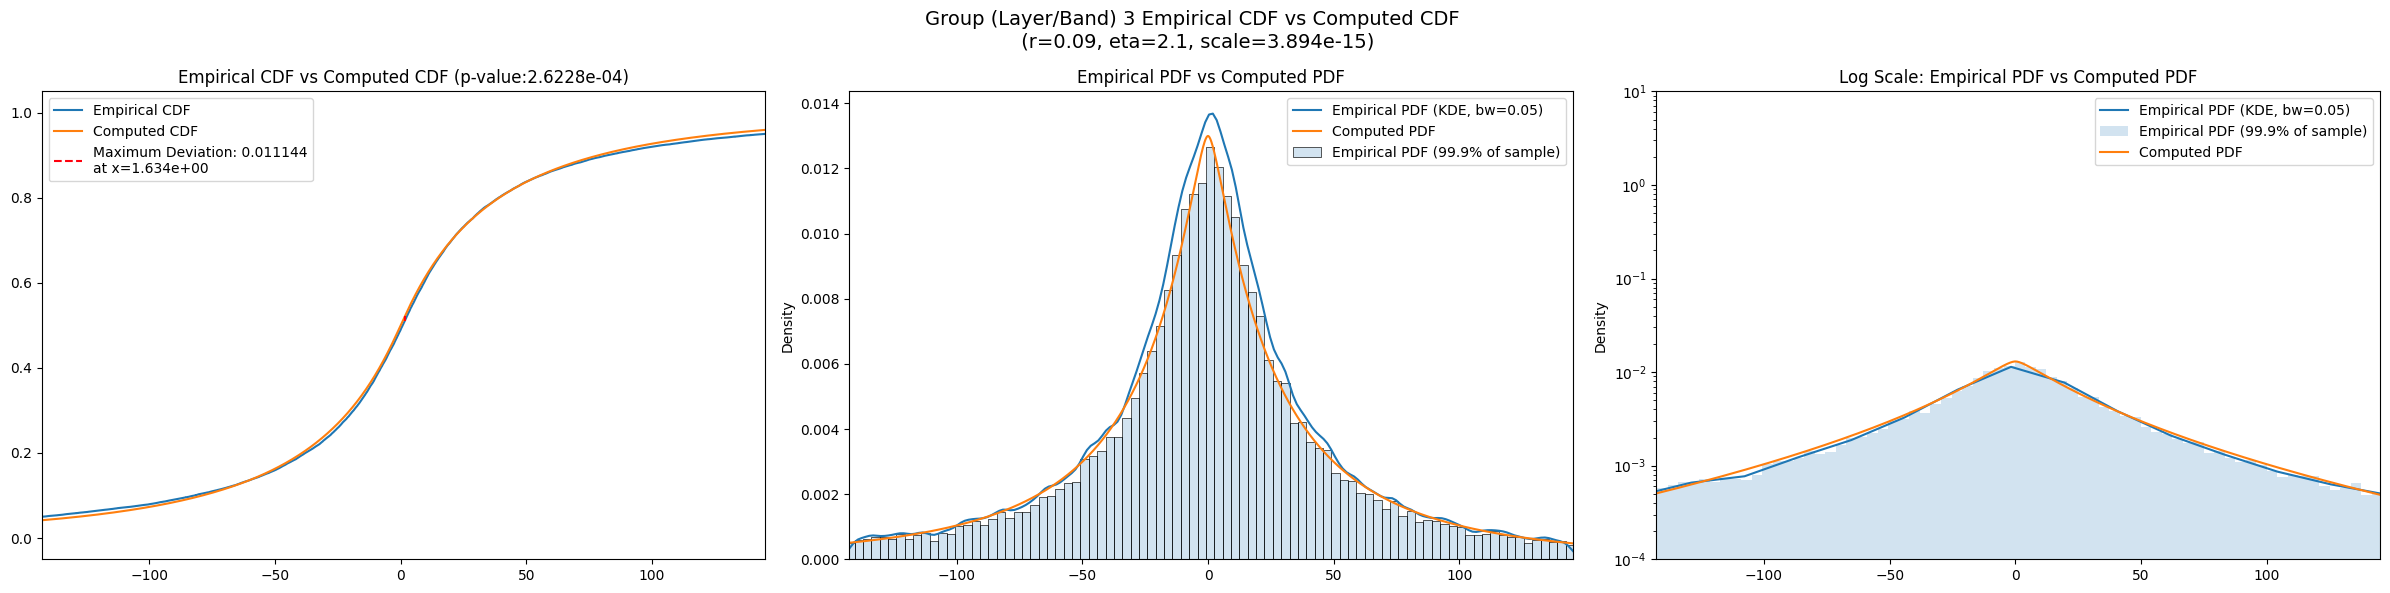

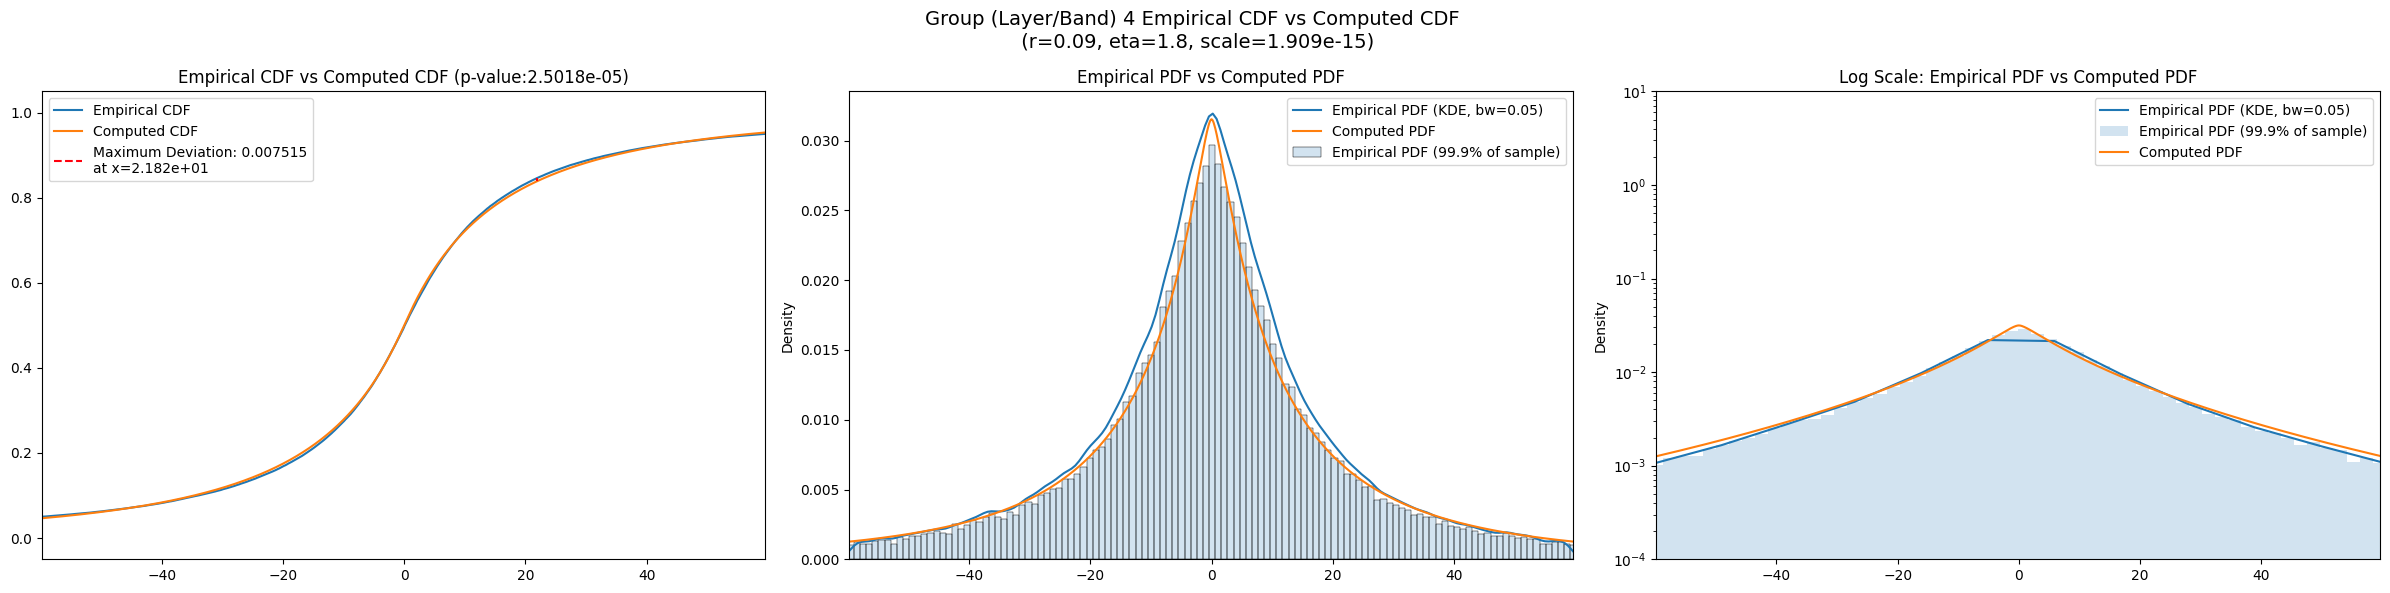

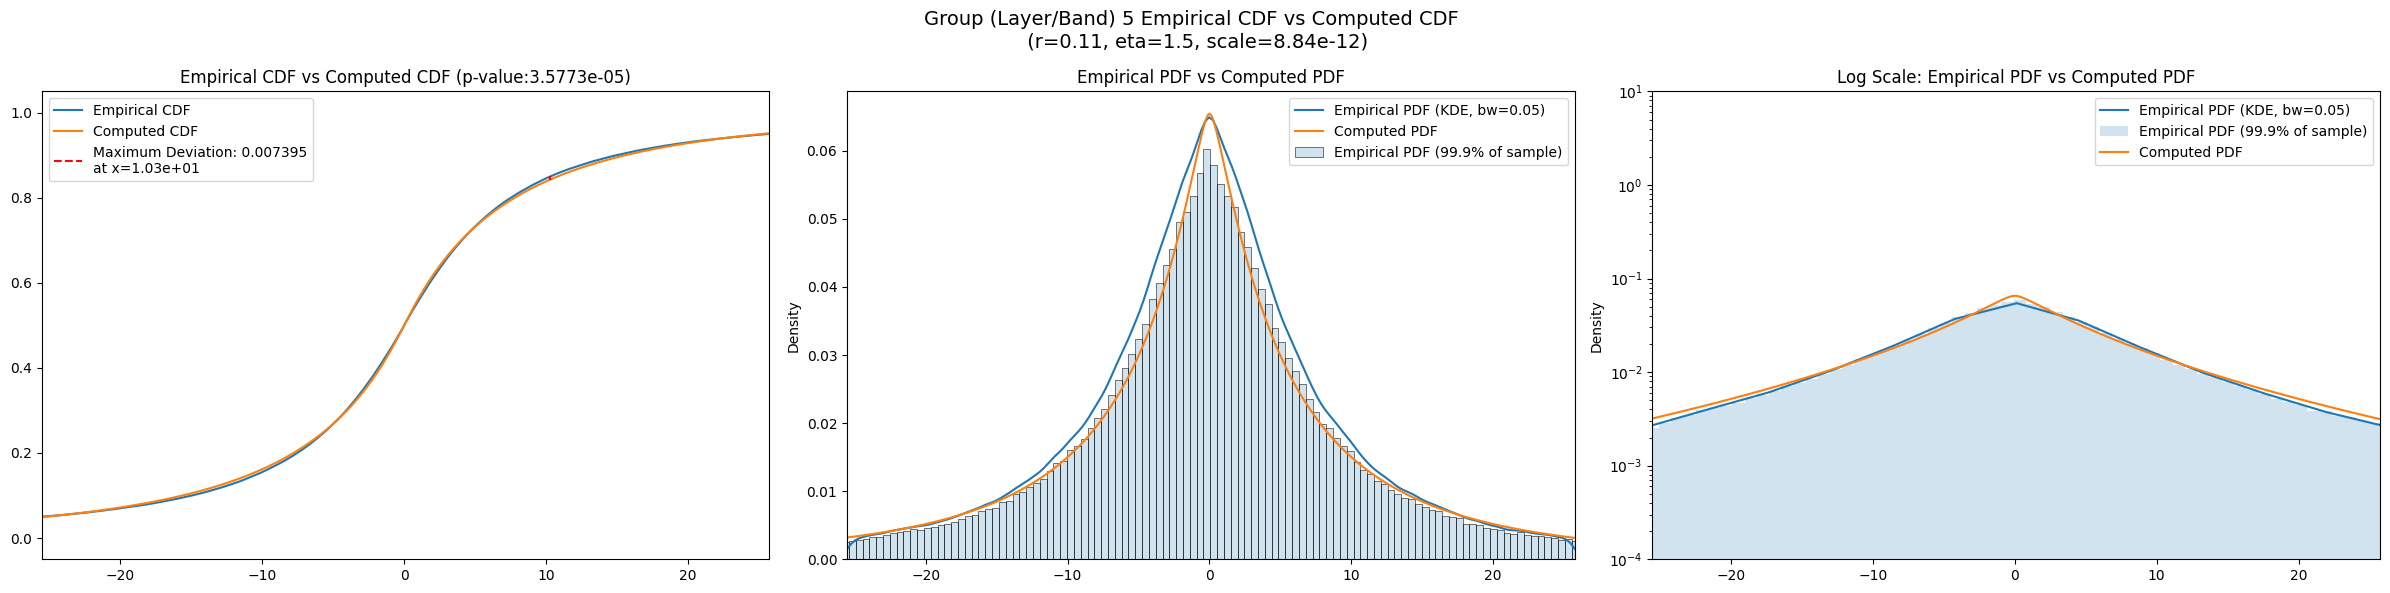

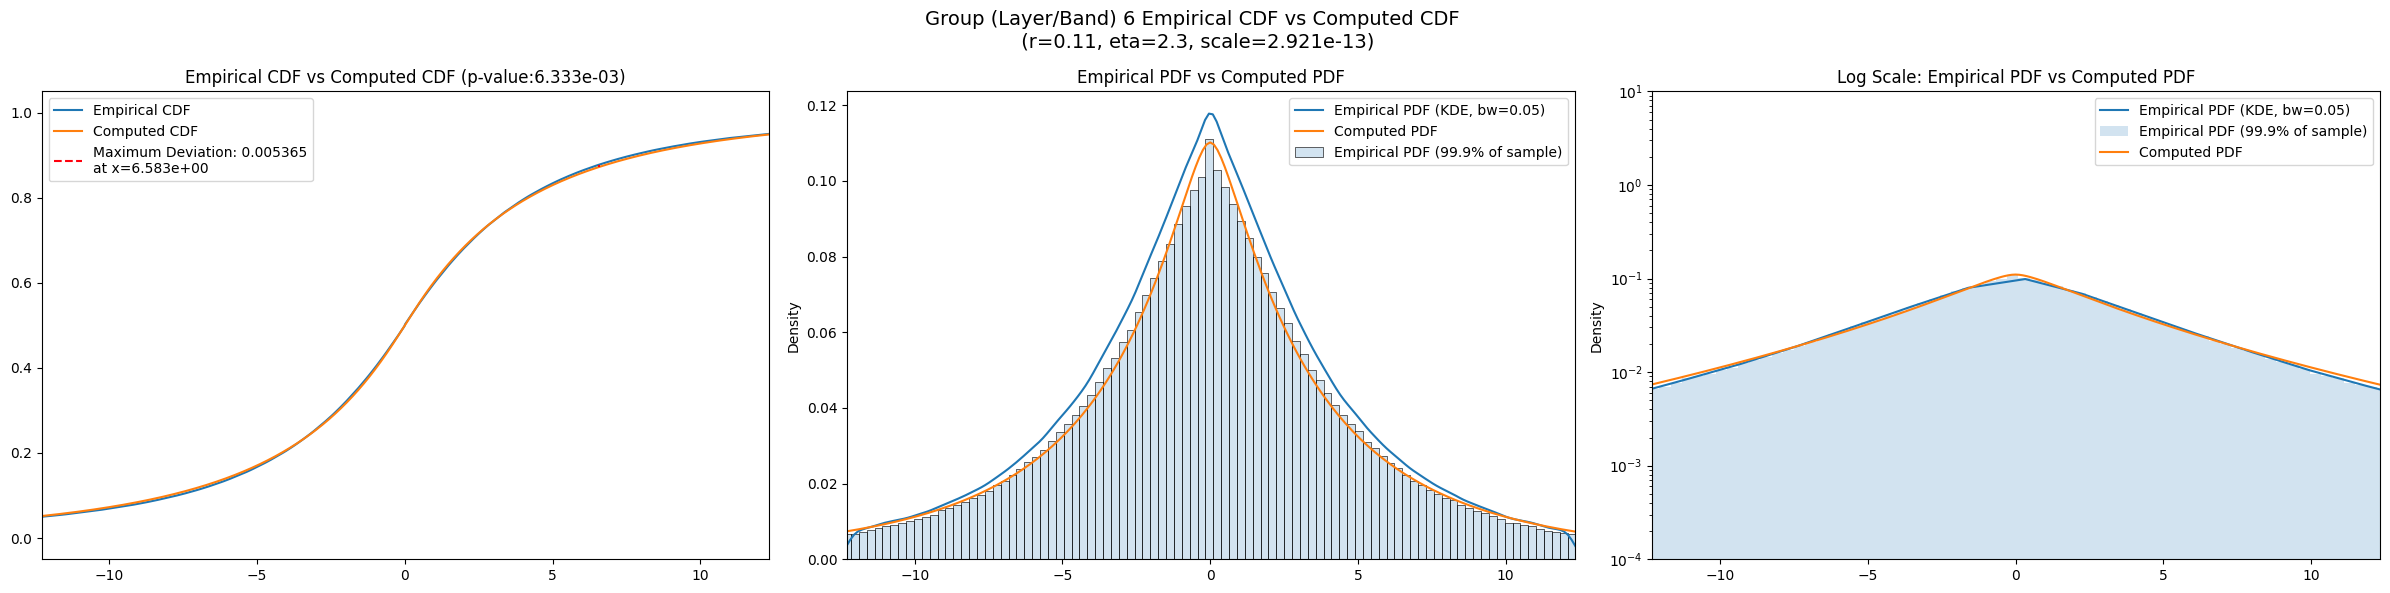

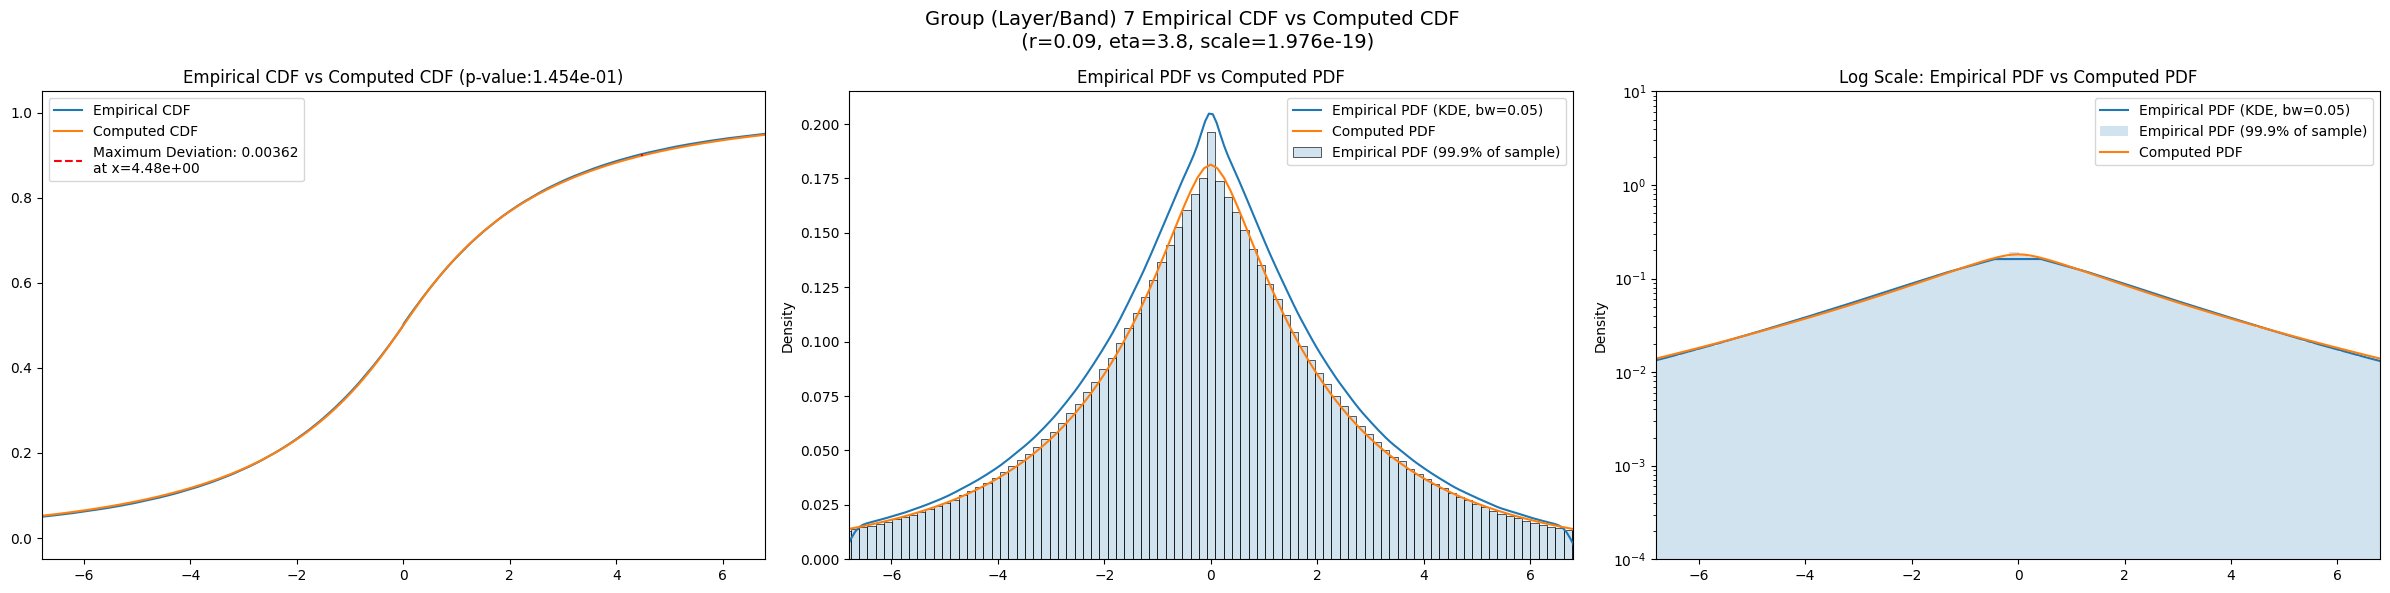

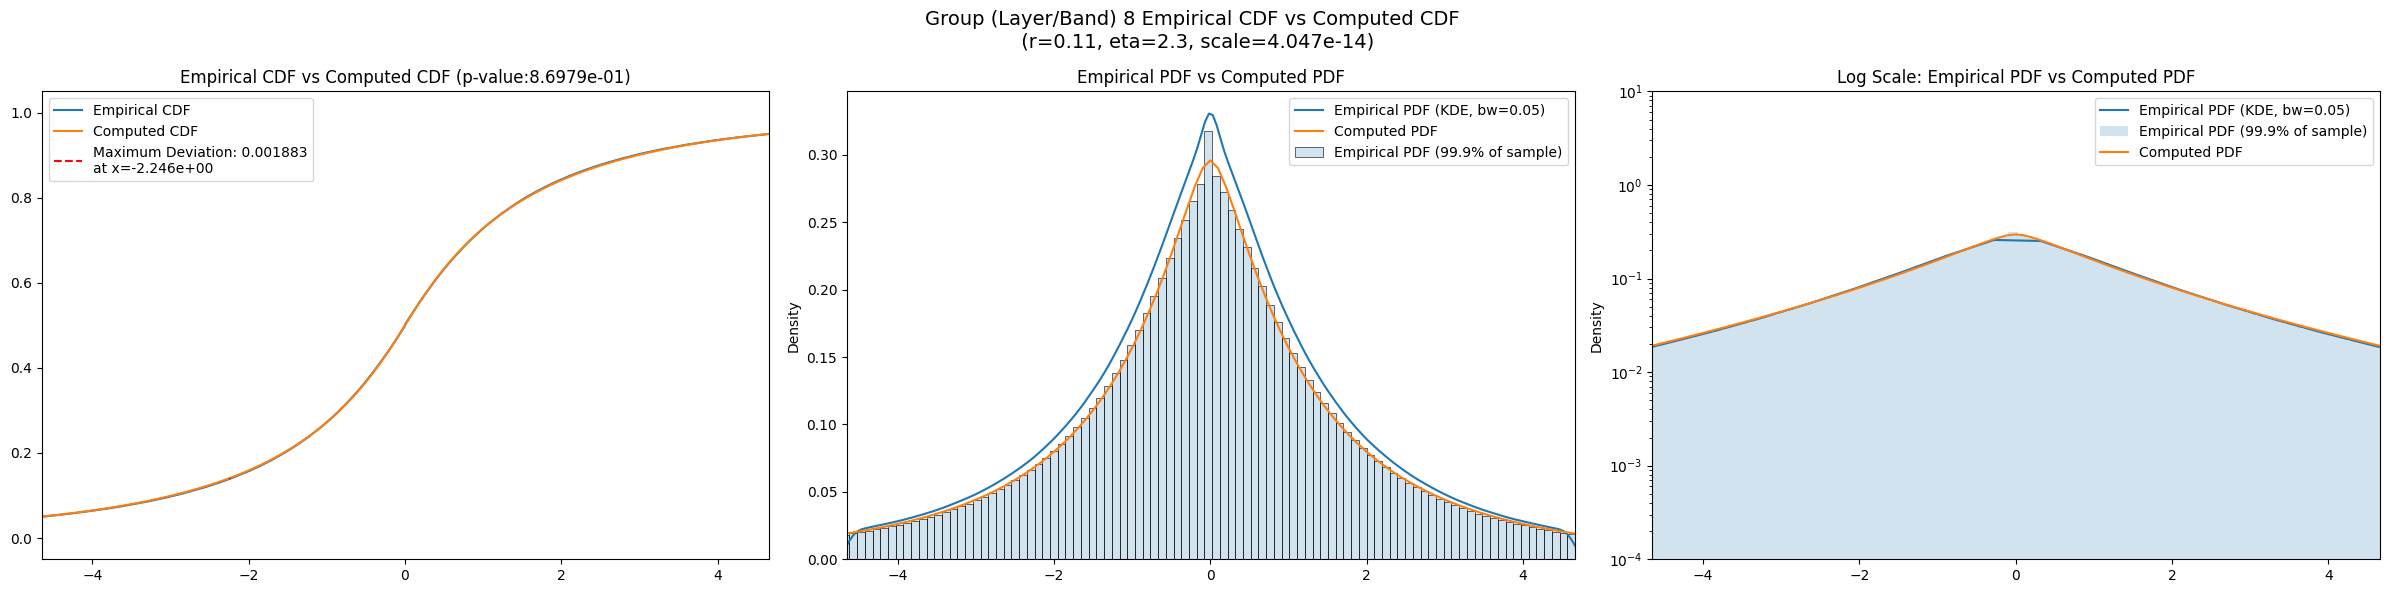

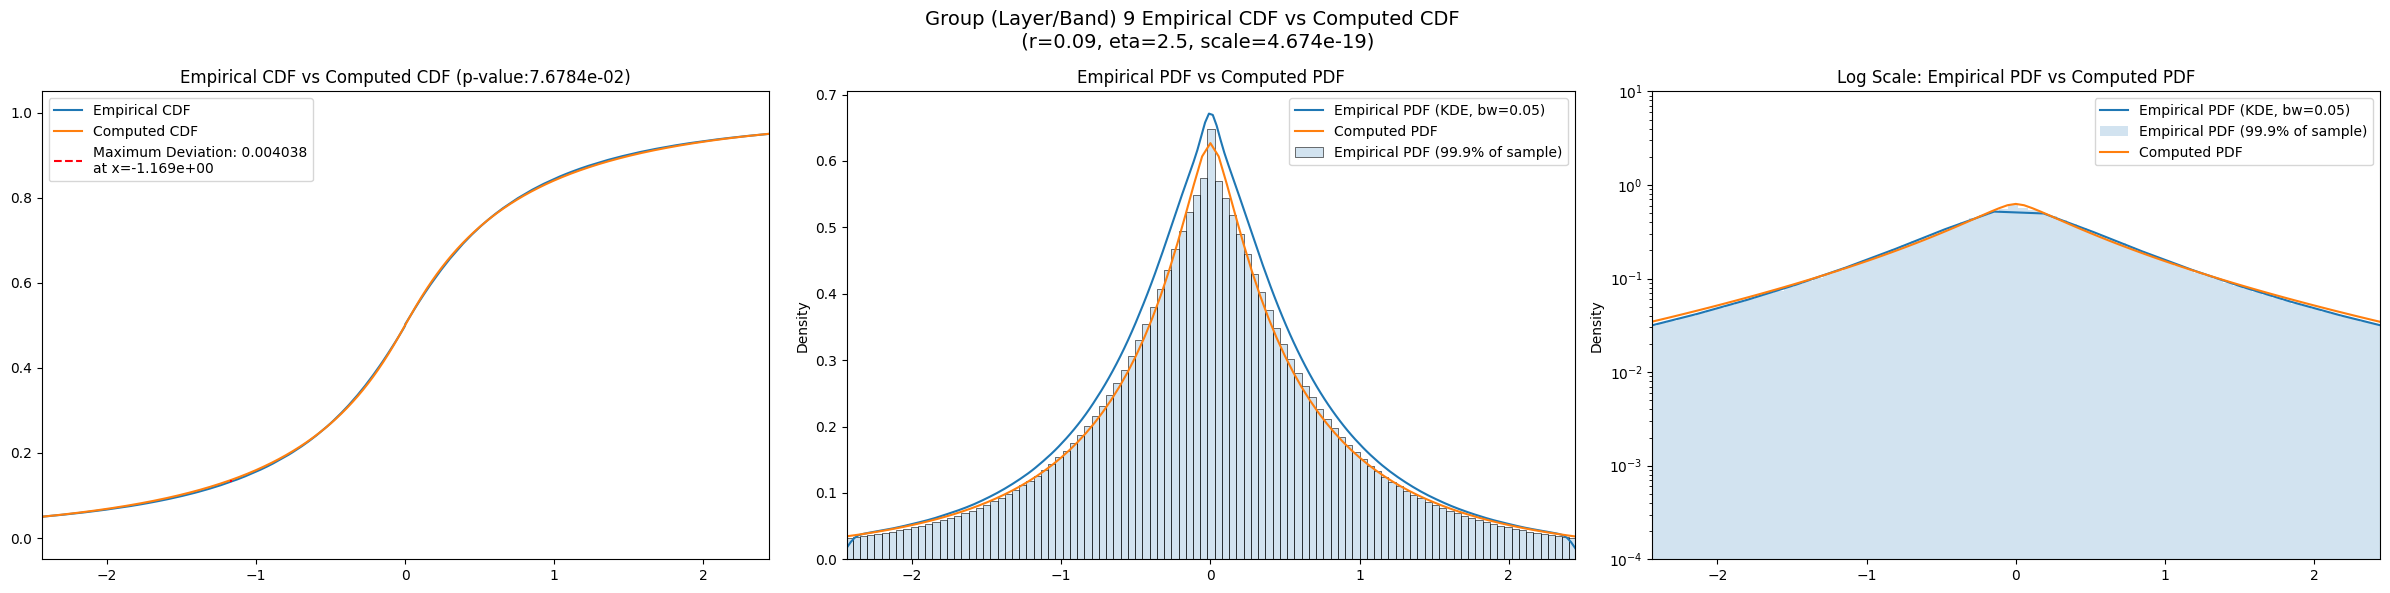

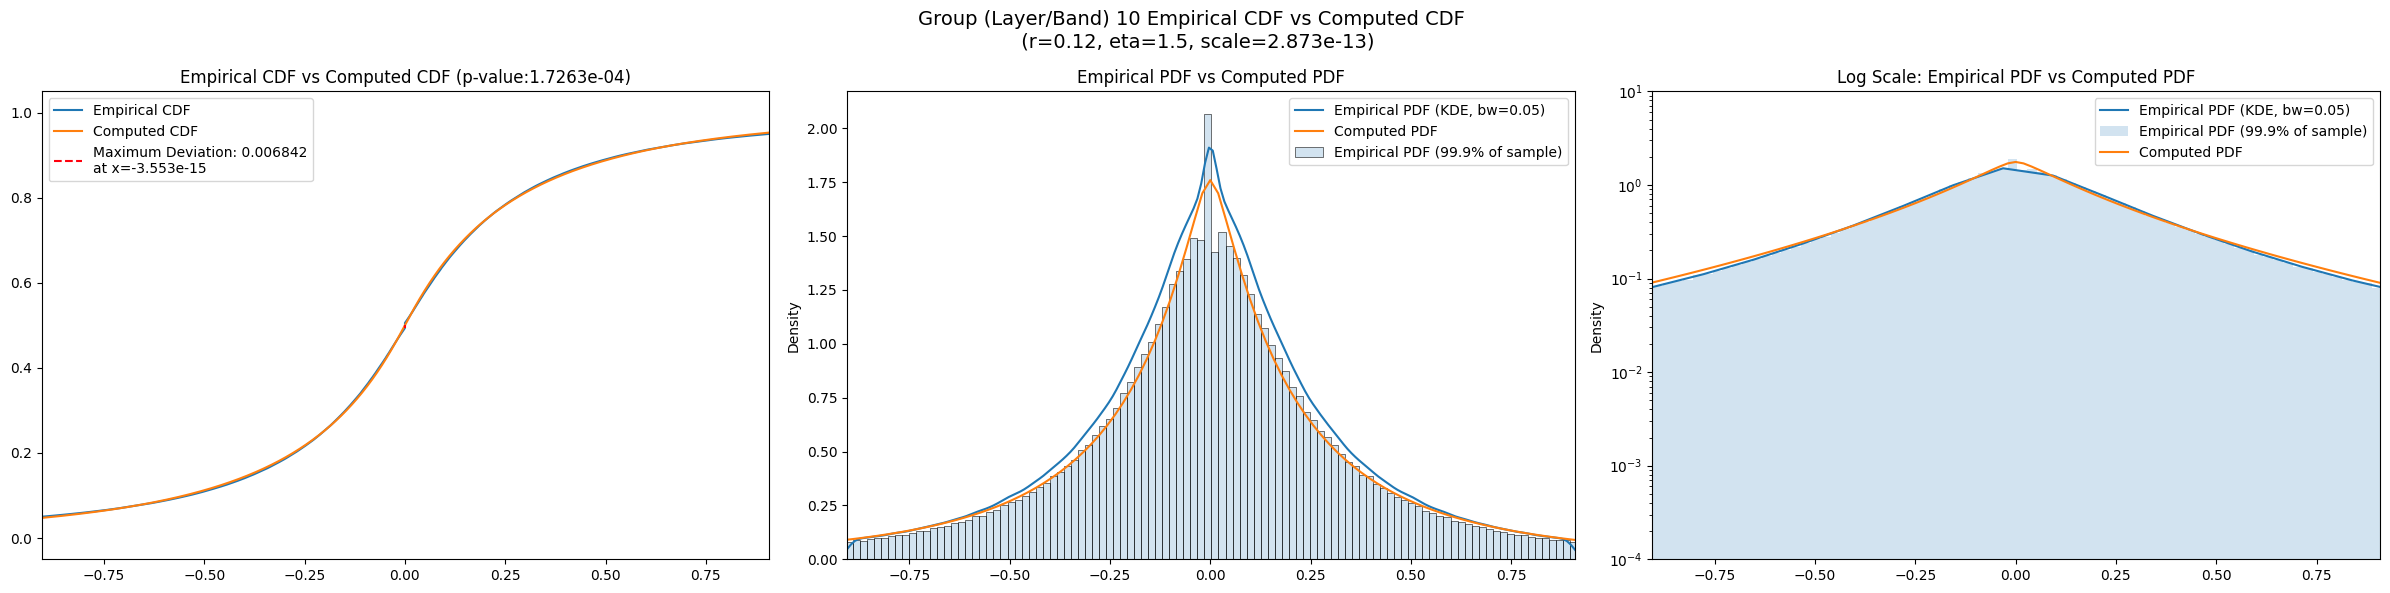

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2      150199.610000  85008.820000  248364.750000   411.56780   85.166885   
3       33515.562000  19958.826000   52689.492000   366.28333  101.325680   
4        8690.716000   4650.655300   15441.943000   584.81120  124.448715   
5        1600.961900    772.053160    3722.834500  1309.72120   95.400870   
6         339.519200    152.123100    1059.839700  2687.21040   93.111470   
7          87.086320     35.836773     371.805480  4823.47600   72.400955   
8          29.883560     15.550574      79.512140  1685.91590   80.564125   
9           8.940126      4.773328      23.294840  1591.25370   83.608900   
10          1.353995      0.687269       4.314201  2561.70360   78.230440   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        581.2459         9000.0             0.012923        0.1          2.1   
3        561.9847        36000.0             0.011263        0.1          1.8   
4       1337.4540       144000.0             0.008796        0.1          1.6   
5       3193.4438       576000.0             0.007817        0.1          1.7   
6       4763.5063      2304000.0             0.005389        0.1          2.6   
7       6356.3230      9216000.0             0.003742        0.1          3.5   
8       3720.9280     36864000.0             0.002191        0.1          2.7   
9       3578.0354    147456000.0             0.003818        0.1          2.2   
10      4657.2515    589824000.0             0.006840        0.1          1.9   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...      126.386000              0.053287          1.188320e-22   
3      ...       51.097400              0.057075         2.235480e-102   
4      ...       21.927100              0.052141          0.000000e+00   
5      ...       10.281000              0.046289          0.000000e+00   
6      ...        5.464020              0.038784          0.000000e+00   
7      ...        3.123040              0.035890          0.000000e+00   
8      ...        2.034520              0.040489          0.000000e+00   
9      ...        1.019810              0.043489          0.000000e+00   
10     ...        0.370727              0.044892          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2         112.080000             0.027644         2.081510e-06  88.349400   
3          45.218000             0.030592         1.054640e-29  35.563000   
4          19.615600             0.027260         2.143050e-93  15.331800   
5           9.169130             0.022133        1.499790e-245   7.236210   
6           4.855720             0.015043         0.000000e+00   3.837810   
7           2.768430             0.011098         0.000000e+00   2.214910   
8           1.797250             0.014289         0.000000e+00   1.433200   
9           0.905438             0.018283         0.000000e+00   0.715500   
10          0.329689             0.020144         0.000000e+00   0.259616   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.024432   4.239170e-05          1.278357e-01  
3           0.028171   2.979370e-25          2.500045e-04  
4           0.022689   7.963070e-65          5.823175e-08  
5           0.015874  1.665910e-126          3.362455e-25  
6           0.009457  2.075710e-179          9.631791e-53  
7           0.009042   0.000000e+00          7.853169e-83  
8           0.012347   0.000000e+00         4.451079e-154  
9           0.014077   0.000000e+00          0.000000e+00  
10        

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.012923                 0.014297          0.012342   
3                 0.011263                 0.007153          0.011168   
4                 0.008796                 0.003578          0.007761   
5                 0.007817                 0.001789          0.007037   
6                 0.005389                 0.000895          0.005113   
7                 0.003742                 0.000447          0.003208   
8                 0.002191                 0.000224          0.002191   
9                 0.003818                 0.000112          0.003805   
10                0.006840                 0.000056          0.006840   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.053287             0.027644       0.024432  
3                  0.057075             0.030592       0.028171  
4                  0.052141             0.027260       0.022689  
5                  0.046289             0.022133       0.015874  
6                  0.038784             0.015043       0.009457  
7                  0.035890             0.011098       0.009042  
8                  0.040489             0.014289       0.012347  
9                  0.043489             0.018283       0.014077  
10                 0.044892             0.020144       0.015220

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            49061.066406          0.012342    0.09       2.5  7.445200e-15   
3             8979.426758          0.011168    0.09       2.1  3.894488e-15   
4             1864.948730          0.007761    0.09       1.8  1.908987e-15   
5              339.475739          0.007037    0.11       1.5  8.839685e-12   
6               75.702705          0.005113    0.11       2.3  2.921297e-13   
7               22.607412          0.003208    0.09       3.8  1.976105e-19   
8               10.488269          0.002191    0.11       2.3  4.047325e-14   
9                3.080054          0.003805    0.09       2.5  4.674097e-19   
10               0.389516          0.006840    0.12       1.5  2.873110e-13   

       best_exclude_cutoff  
layer                       
2                     25.0  
3                    175.0  
4                    425.0  
5                    400.0  
6                    325.0  
7                    200.0  
8                    150.0  
9                    175.0  
10                   300.0

In [21]:
eng.quit()